In [1]:
import findspark
import pandas as pd
findspark.init()
from pyspark.sql import SQLContext
from pyspark import SparkContext
sc = SparkContext()
sqlContext = SQLContext(sc)
data_input = sqlContext.read.format("com.databricks.spark.csv").options( header = True, inferSchema = True, sep=';',  line_terminator='\n').load( path='C:\\Users\\yhoz\\Documents\\dataanalytics.predictive\\data\\input.csv')
anual_data = sqlContext.read.format("com.databricks.spark.csv").options( header = True, sep=';',  line_terminator='\n').schema(data_input.schema).load( path='C:\\Users\\yhoz\\Documents\\dataanalytics.predictive\\models\\01_horus_traffic_prediction\\desc_ref\\anual_data_2018.csv')

In [2]:
anual_data.printSchema()

root
 |-- ID_SEGMENT: integer (nullable = true)
 |-- COD_LABORALIDAD: integer (nullable = true)
 |-- FECHA: timestamp (nullable = true)
 |-- MES: integer (nullable = true)
 |-- HORA: integer (nullable = true)
 |-- MINUTO: integer (nullable = true)
 |-- CANTIDAD_PREC: double (nullable = true)
 |-- TOTAL_VEHICULOS: integer (nullable = true)
 |-- TOTAL_VEHICULOS_1: integer (nullable = true)
 |-- TOTAL_VEHICULOS_2: integer (nullable = true)
 |-- TOTAL_VEHICULOS_3: integer (nullable = true)
 |-- TOTAL_VEHICULOS_4: integer (nullable = true)
 |-- TOTAL_VEHICULOS_5: integer (nullable = true)
 |-- TOTAL_VEHICULOS_6: integer (nullable = true)
 |-- TOTAL_VEHICULOS_7: integer (nullable = true)
 |-- TOTAL_VEHICULOS_8: integer (nullable = true)
 |-- TOTAL_VEHICULOS_9: integer (nullable = true)
 |-- TOTAL_VEHICULOS_10: integer (nullable = true)
 |-- TOTAL_VEHICULOS_11: integer (nullable = true)
 |-- TOTAL_VEHICULOS_12: integer (nullable = true)
 |-- TOTAL_VEHICULOS_13: integer (nullable = true)
 |-- 

In [3]:
df_anual_data= anual_data.toPandas()

In [4]:
df_anual_data.isnull().any().sum()
df_anual_data = df_anual_data.dropna(how='any')
df_anual_data["TOTAL_VEHICULOS"].fillna(df_anual_data["TOTAL_VEHICULOS"].mean(),inplace=True)

In [5]:
df_anual_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 691900 entries, 0 to 701044
Data columns (total 32 columns):
ID_SEGMENT            691900 non-null float64
COD_LABORALIDAD       691900 non-null float64
FECHA                 691900 non-null datetime64[ns]
MES                   691900 non-null float64
HORA                  691900 non-null float64
MINUTO                691900 non-null float64
CANTIDAD_PREC         691900 non-null float64
TOTAL_VEHICULOS       691900 non-null float64
TOTAL_VEHICULOS_1     691900 non-null float64
TOTAL_VEHICULOS_2     691900 non-null float64
TOTAL_VEHICULOS_3     691900 non-null float64
TOTAL_VEHICULOS_4     691900 non-null float64
TOTAL_VEHICULOS_5     691900 non-null float64
TOTAL_VEHICULOS_6     691900 non-null float64
TOTAL_VEHICULOS_7     691900 non-null float64
TOTAL_VEHICULOS_8     691900 non-null float64
TOTAL_VEHICULOS_9     691900 non-null float64
TOTAL_VEHICULOS_10    691900 non-null float64
TOTAL_VEHICULOS_11    691900 non-null float64
TOTAL_VE

In [6]:
from datetime import datetime, timedelta 
df_anual_data['TIME'] = pd.to_datetime(df_anual_data['FECHA']).map(lambda x: x.strftime('%H:%M:%S'))
df_anual_data.TIME[:5]

0    00:00:00
1    00:00:00
2    00:00:00
3    00:00:00
4    00:00:00
Name: TIME, dtype: object

### Generate Training Datasets

In [7]:
months = df_anual_data.FECHA.dt.month.unique()
segments = df_anual_data.ID_SEGMENT.unique()
codes = df_anual_data.COD_LABORALIDAD.unique()

print("Months " + str(months))
print("Segments " + str(segments))
print("Codes " + str(codes))

total_trainsets = len(months) * len(segments) * len(codes)
print("Number of training sets: " + str(total_trainsets))

Months [ 1  2  3  4  5  6  7  8  9 10 11 12]
Segments [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]
Codes [2. 1. 3. 4. 5. 6. 7.]
Number of training sets: 1680


In [8]:
rows_per_day=int(((60/15)*24))

training_sets = {'ID_SEGMENT':[], 'MES':[], 'TRAINING_SET':[] }
for seg_id in segments: # 1) Particionar anual_data por segmento
    df_seg = df_anual_data.loc[df_anual_data.ID_SEGMENT==seg_id]
    for month_i in df_seg.FECHA.dt.month.unique(): # 2) Dividir mensual_data en 12 datasets 
        df_month_seg = df_seg.loc[df_seg.FECHA.dt.month==month_i]
        #for code_i in df_month_seg.COD_LABORALIDAD.unique(): # 3) Particionar por dias con mismo código de lab
        #    df_month_seg_code = df_month_seg.loc[df_month_seg.COD_LABORALIDAD==code_i]
                
            # Fill training_sets dictionary
            
        training_sets['ID_SEGMENT'].append(seg_id)
        training_sets['MES'].append(month_i)
        #training_sets['COD_LABORALIDAD'].append(code_i)
        training_sets['TRAINING_SET'].append(df_month_seg)
            

In [9]:
for row in range(0,total_trainsets):
    print("----------------------------> TRAINING SET NUMBER: " + str(row))
    print("SEGMENTO " + str(training_sets['ID_SEGMENT'][row]))
    print("MES " + str(training_sets['MES'][row]))
    #print("COD_LABORALIDAD " + str(training_sets['COD_LABORALIDAD'][row]))
    print("DAYS IN TRAINING_SET: " + str(training_sets['TRAINING_SET'][row].FECHA.dt.day.unique()))

----------------------------> TRAINING SET NUMBER: 0
SEGMENTO 1.0
MES 1
DAYS IN TRAINING_SET: [ 1 28 29 30 31  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
 21 22 23 24 25 26 27]
----------------------------> TRAINING SET NUMBER: 1
SEGMENTO 1.0
MES 2
DAYS IN TRAINING_SET: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
----------------------------> TRAINING SET NUMBER: 2
SEGMENTO 1.0
MES 3
DAYS IN TRAINING_SET: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
----------------------------> TRAINING SET NUMBER: 3
SEGMENTO 1.0
MES 4
DAYS IN TRAINING_SET: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
----------------------------> TRAINING SET NUMBER: 4
SEGMENTO 1.0
MES 5
DAYS IN TRAINING_SET: [ 1  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31  2  3]
----------------------------> TRAINING SET NUMBER: 5
SEGMENTO 

 22 23 24 25 26 27 28]
----------------------------> TRAINING SET NUMBER: 96
SEGMENTO 9.0
MES 1
DAYS IN TRAINING_SET: [ 1 28 29 30 31  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
 21 22 23 24 25 26 27]
----------------------------> TRAINING SET NUMBER: 97
SEGMENTO 9.0
MES 2
DAYS IN TRAINING_SET: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
----------------------------> TRAINING SET NUMBER: 98
SEGMENTO 9.0
MES 3
DAYS IN TRAINING_SET: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
----------------------------> TRAINING SET NUMBER: 99
SEGMENTO 9.0
MES 4
DAYS IN TRAINING_SET: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
----------------------------> TRAINING SET NUMBER: 100
SEGMENTO 9.0
MES 5
DAYS IN TRAINING_SET: [ 1  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31  2  3]
----------------------------> TRA

DAYS IN TRAINING_SET: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
----------------------------> TRAINING SET NUMBER: 177
SEGMENTO 15.0
MES 10
DAYS IN TRAINING_SET: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
----------------------------> TRAINING SET NUMBER: 178
SEGMENTO 15.0
MES 11
DAYS IN TRAINING_SET: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
----------------------------> TRAINING SET NUMBER: 179
SEGMENTO 15.0
MES 12
DAYS IN TRAINING_SET: [ 1 29 30 31  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25 26 27 28]
----------------------------> TRAINING SET NUMBER: 180
SEGMENTO 16.0
MES 1
DAYS IN TRAINING_SET: [ 1 28 29 30 31  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
 21 22 23 24 25 26 27]
----------------------------> TRAINING SET NUMBER: 181
SEGMENTO 16.0
MES 2
DAYS IN TRAINING_SET: [ 1  2  3  4  5 

IndexError: list index out of range

In [11]:
df_training_sets = pd.DataFrame(training_sets)
df_training_sets.info()
df_training_sets['TRAINING_SET'].iloc[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 3 columns):
ID_SEGMENT      240 non-null float64
MES             240 non-null int64
TRAINING_SET    240 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 5.7+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2977 entries, 0 to 647693
Data columns (total 33 columns):
ID_SEGMENT            2977 non-null float64
COD_LABORALIDAD       2977 non-null float64
FECHA                 2977 non-null datetime64[ns]
MES                   2977 non-null float64
HORA                  2977 non-null float64
MINUTO                2977 non-null float64
CANTIDAD_PREC         2977 non-null float64
TOTAL_VEHICULOS       2977 non-null float64
TOTAL_VEHICULOS_1     2977 non-null float64
TOTAL_VEHICULOS_2     2977 non-null float64
TOTAL_VEHICULOS_3     2977 non-null float64
TOTAL_VEHICULOS_4     2977 non-null float64
TOTAL_VEHICULOS_5     2977 non-null float64
TOTAL_VEHICULOS_6     2977 non-null fl

### Model Training

In [12]:
# Start taking the training set --> Month 4, Segment 1
month_i = 4
seg_id = 1
df_train_start = df_training_sets.loc[(df_training_sets.MES==month_i)&(df_training_sets.ID_SEGMENT==seg_id)]['TRAINING_SET'].iloc[0]
df_train_start.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2881 entries, 172842 to 230443
Data columns (total 33 columns):
ID_SEGMENT            2881 non-null float64
COD_LABORALIDAD       2881 non-null float64
FECHA                 2881 non-null datetime64[ns]
MES                   2881 non-null float64
HORA                  2881 non-null float64
MINUTO                2881 non-null float64
CANTIDAD_PREC         2881 non-null float64
TOTAL_VEHICULOS       2881 non-null float64
TOTAL_VEHICULOS_1     2881 non-null float64
TOTAL_VEHICULOS_2     2881 non-null float64
TOTAL_VEHICULOS_3     2881 non-null float64
TOTAL_VEHICULOS_4     2881 non-null float64
TOTAL_VEHICULOS_5     2881 non-null float64
TOTAL_VEHICULOS_6     2881 non-null float64
TOTAL_VEHICULOS_7     2881 non-null float64
TOTAL_VEHICULOS_8     2881 non-null float64
TOTAL_VEHICULOS_9     2881 non-null float64
TOTAL_VEHICULOS_10    2881 non-null float64
TOTAL_VEHICULOS_11    2881 non-null float64
TOTAL_VEHICULOS_12    2881 non-null float64

### Generate fbprophet model with this training set

In [13]:
from fbprophet import Prophet

In [62]:
df_training_prophet = df_train_start[['FECHA','TOTAL_VEHICULOS']].rename(columns={"FECHA": "ds", "TOTAL_VEHICULOS": "y"})
df_training_prophet = df_training_prophet.reset_index(drop=True)

In [63]:
df_training_prophet.head()

ds      y
0 2018-04-01 00:00:00  206.0
1 2018-04-01 00:00:00  206.0
2 2018-04-01 00:15:00  189.0
3 2018-04-01 00:30:00  213.0
4 2018-04-01 00:45:00  167.0

In [64]:
df_training_prophet.drop_duplicates(subset=['ds', 'y'], keep='first', inplace=True)
df_training_prophet.head()

ds      y
0 2018-04-01 00:00:00  206.0
2 2018-04-01 00:15:00  189.0
3 2018-04-01 00:30:00  213.0
4 2018-04-01 00:45:00  167.0
5 2018-04-01 01:00:00  142.0

In [65]:
df_training_prophet.ds.dt.day.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], dtype=int64)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


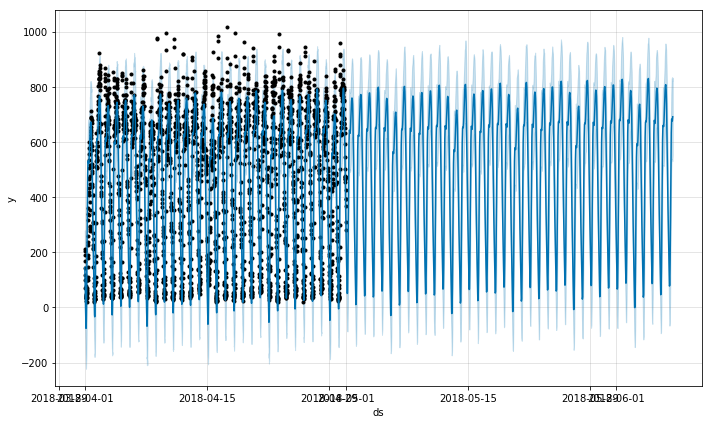

In [68]:
time_resolution = 60*15 # 60 mint in 1 hour
m = Prophet(changepoint_prior_scale=0.01).fit(df_training_prophet)
future = m.make_future_dataframe(periods=time_resolution, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

In [69]:
fcst.head()

ds       trend  yhat_lower  yhat_upper  trend_lower  \
0 2018-04-01 00:00:00  443.372901   -2.639721  279.713604   443.372901   
1 2018-04-01 00:15:00  443.384846  -12.121649  272.960192   443.384846   
2 2018-04-01 00:30:00  443.396792  -28.558122  252.014627   443.396792   
3 2018-04-01 00:45:00  443.408737  -54.688503  228.558239   443.408737   
4 2018-04-01 01:00:00  443.420682  -79.118292  204.203702   443.420682   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0   443.372901     -297.857991           -297.857991           -297.857991   
1   443.384846     -316.948353           -316.948353           -316.948353   
2   443.396792     -336.825691           -336.825691           -336.825691   
3   443.408737     -357.500663           -357.500663           -357.500663   
4   443.420682     -378.847292           -378.847292           -378.847292   

        daily  daily_lower  daily_upper     weekly  weekly_lower  \
0 -251.146705  -251.146705  -251.146705 -46.711286    -46.711286   
1 -269.240709  -269.240709  -269.240709 -47.707644    -47.707644   
2 -288.137064  -288.137064  -288.137064 -48.688627    -48.688627   
3 -307.847001  -307.847001  -307.847001 -49.653662    -49.653662   
4 -328.245106  -328.245106  -328.245106 -50.602186    -50.602186   

   weekly_upper  multiplicative_terms  multiplicative_terms_lower  \
0    -46.711286                   0.0                         0.0   
1    -47.707644                   0.0                         0.0   
2    -48.688627                   0.0                         0.0   
3    -49.653662                   0.0                         0.0   
4    -50.602186                   0.0                         0.0   

   multiplicative_terms_upper        yhat  
0                         0.0  145.514910  
1                         0.0  126.436493  
2                         0.0  106.571101  
3                         0.0   85.908074  
4                         0.0   64.573390

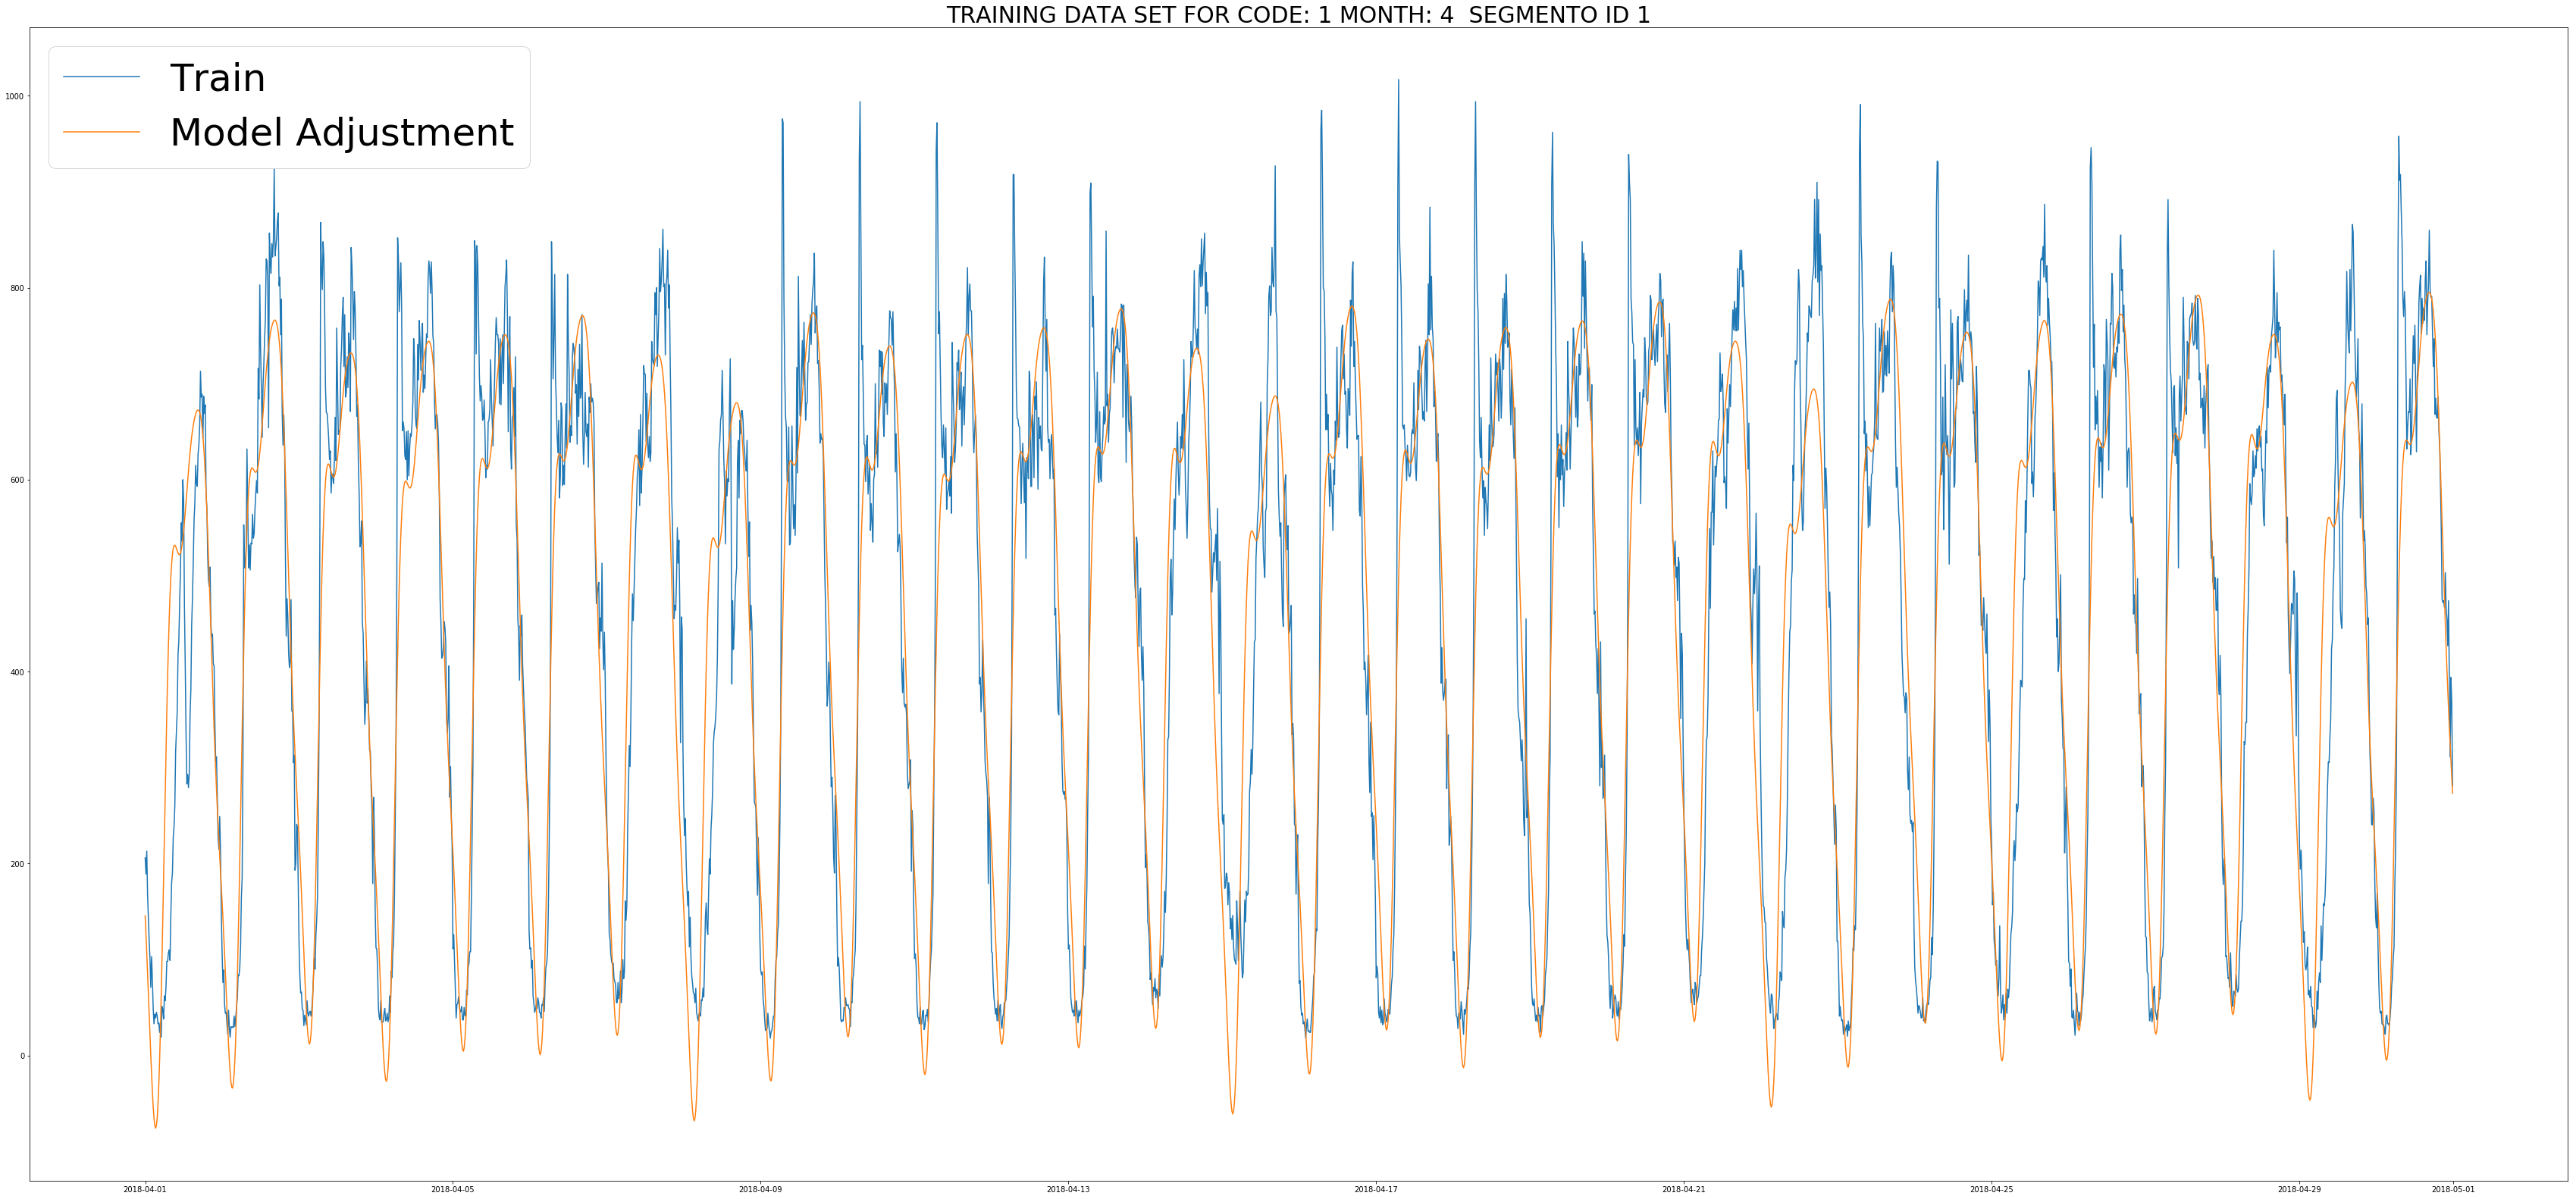

In [72]:
plt.figure(figsize=(60,28))
plt.title('TRAINING DATA SET FOR CODE: ' + str(code_i) + ' MONTH: 4 '  + ' SEGMENTO ID ' + str(seg_id) ,  fontsize=30)
plt.plot(df_training_prophet.ds, df_training_prophet.y, marker='', label=str("Train"))
plt.plot(fcst.loc[fcst.ds.dt.month==4].ds, fcst.loc[fcst.ds.dt.month==4].yhat, marker='', label=str("Model Adjustment"))
plt.legend(loc='best',  fontsize=10)
plt.show()

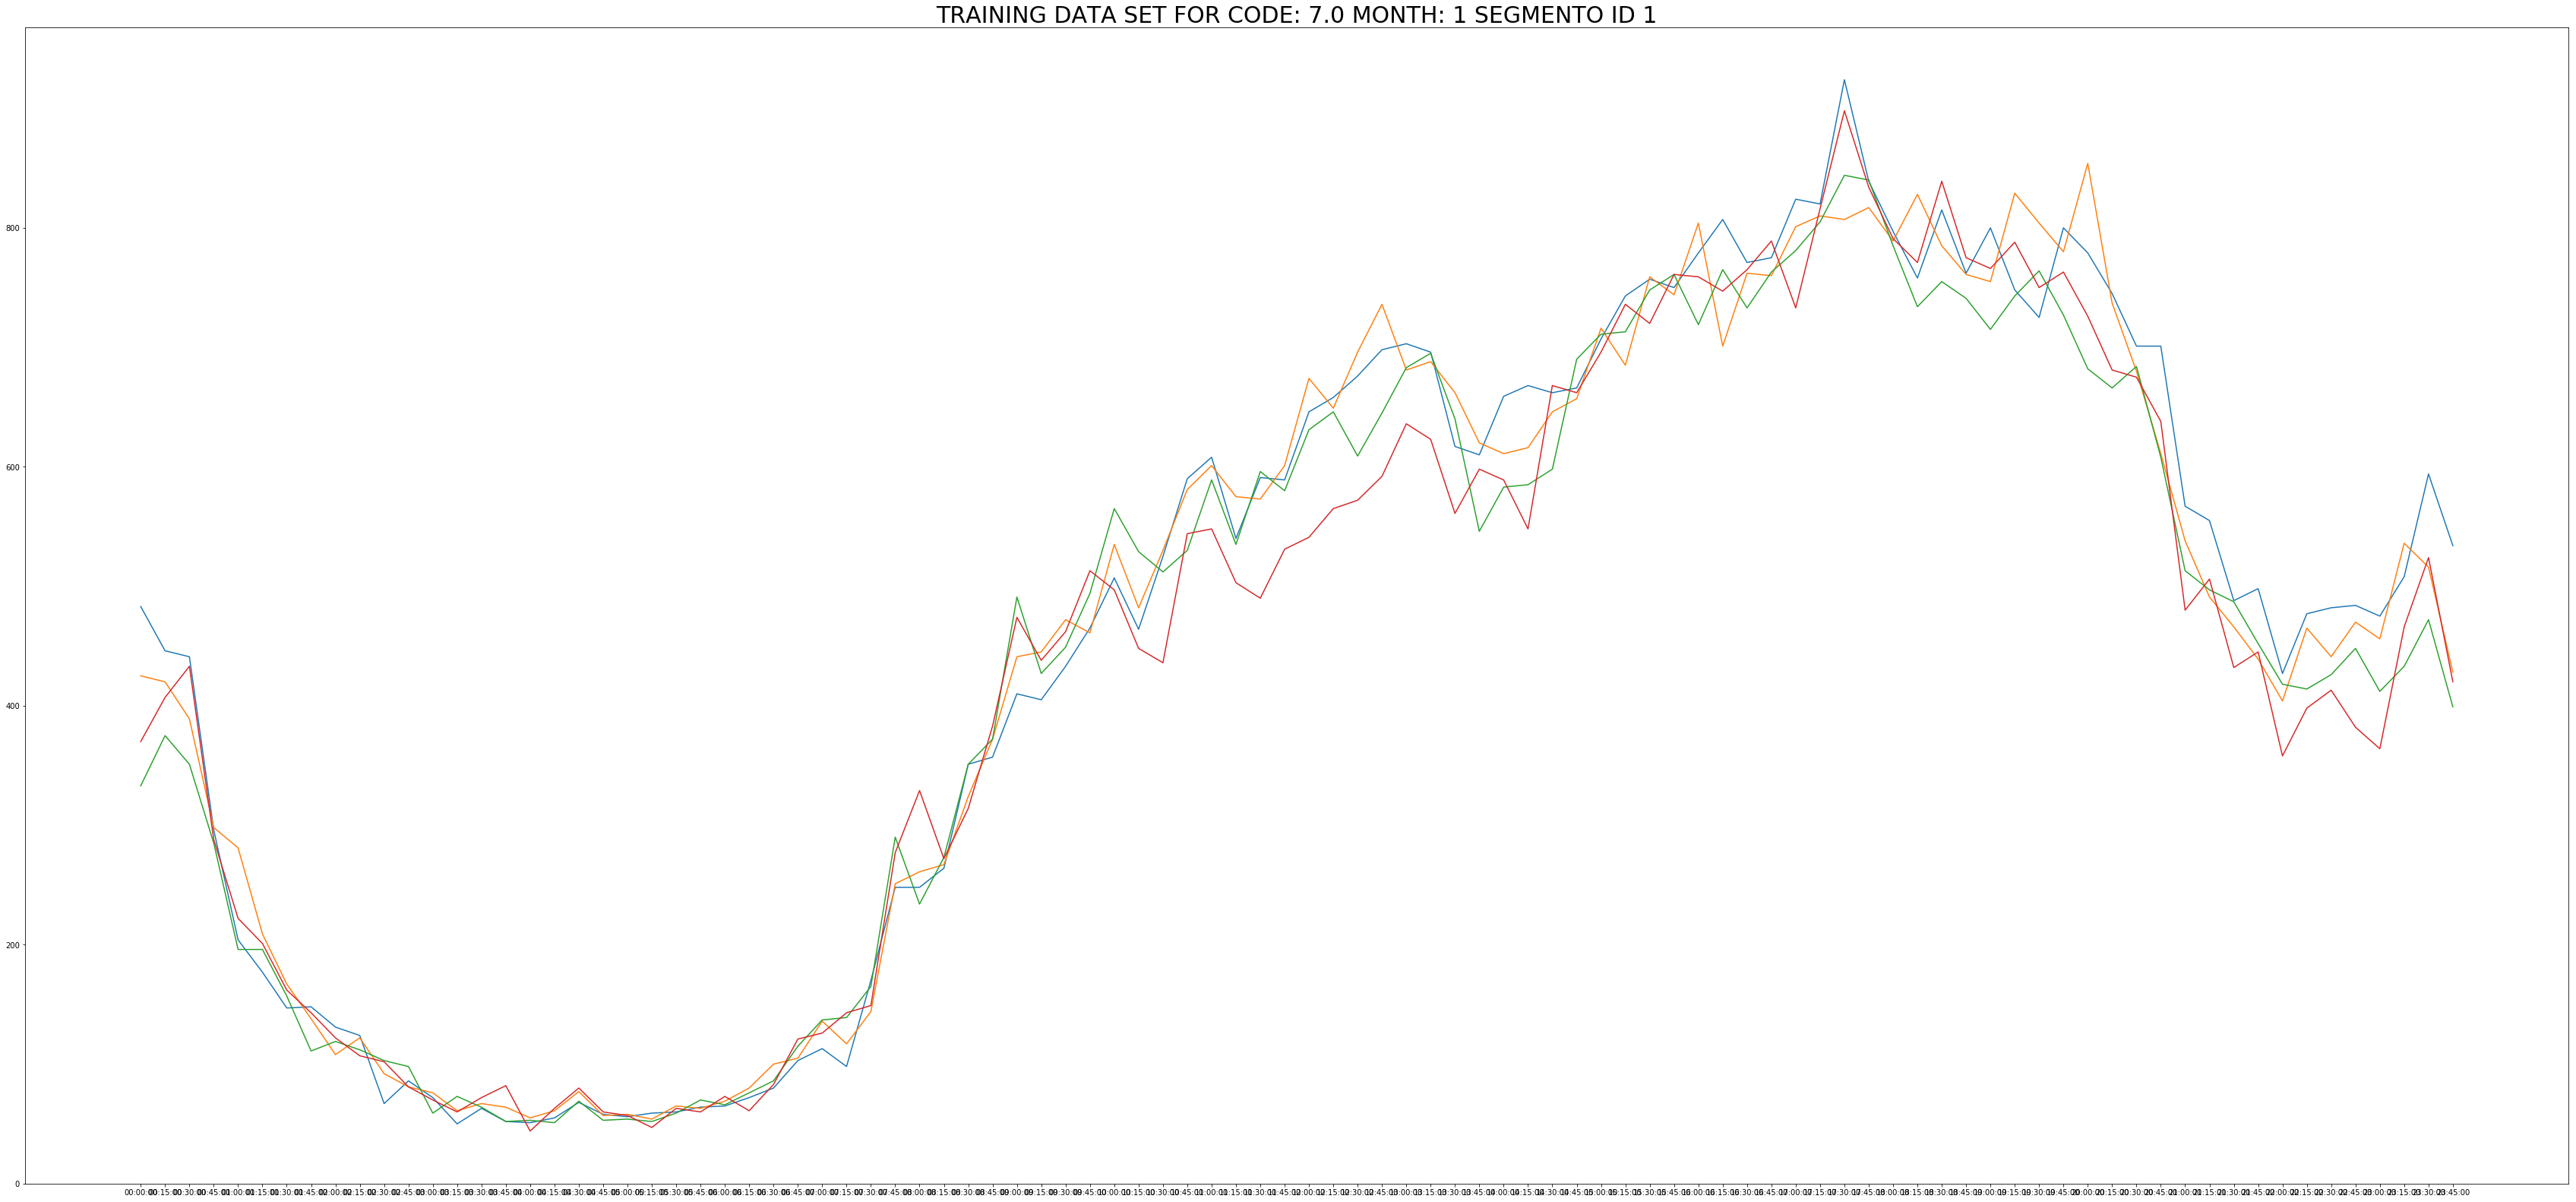

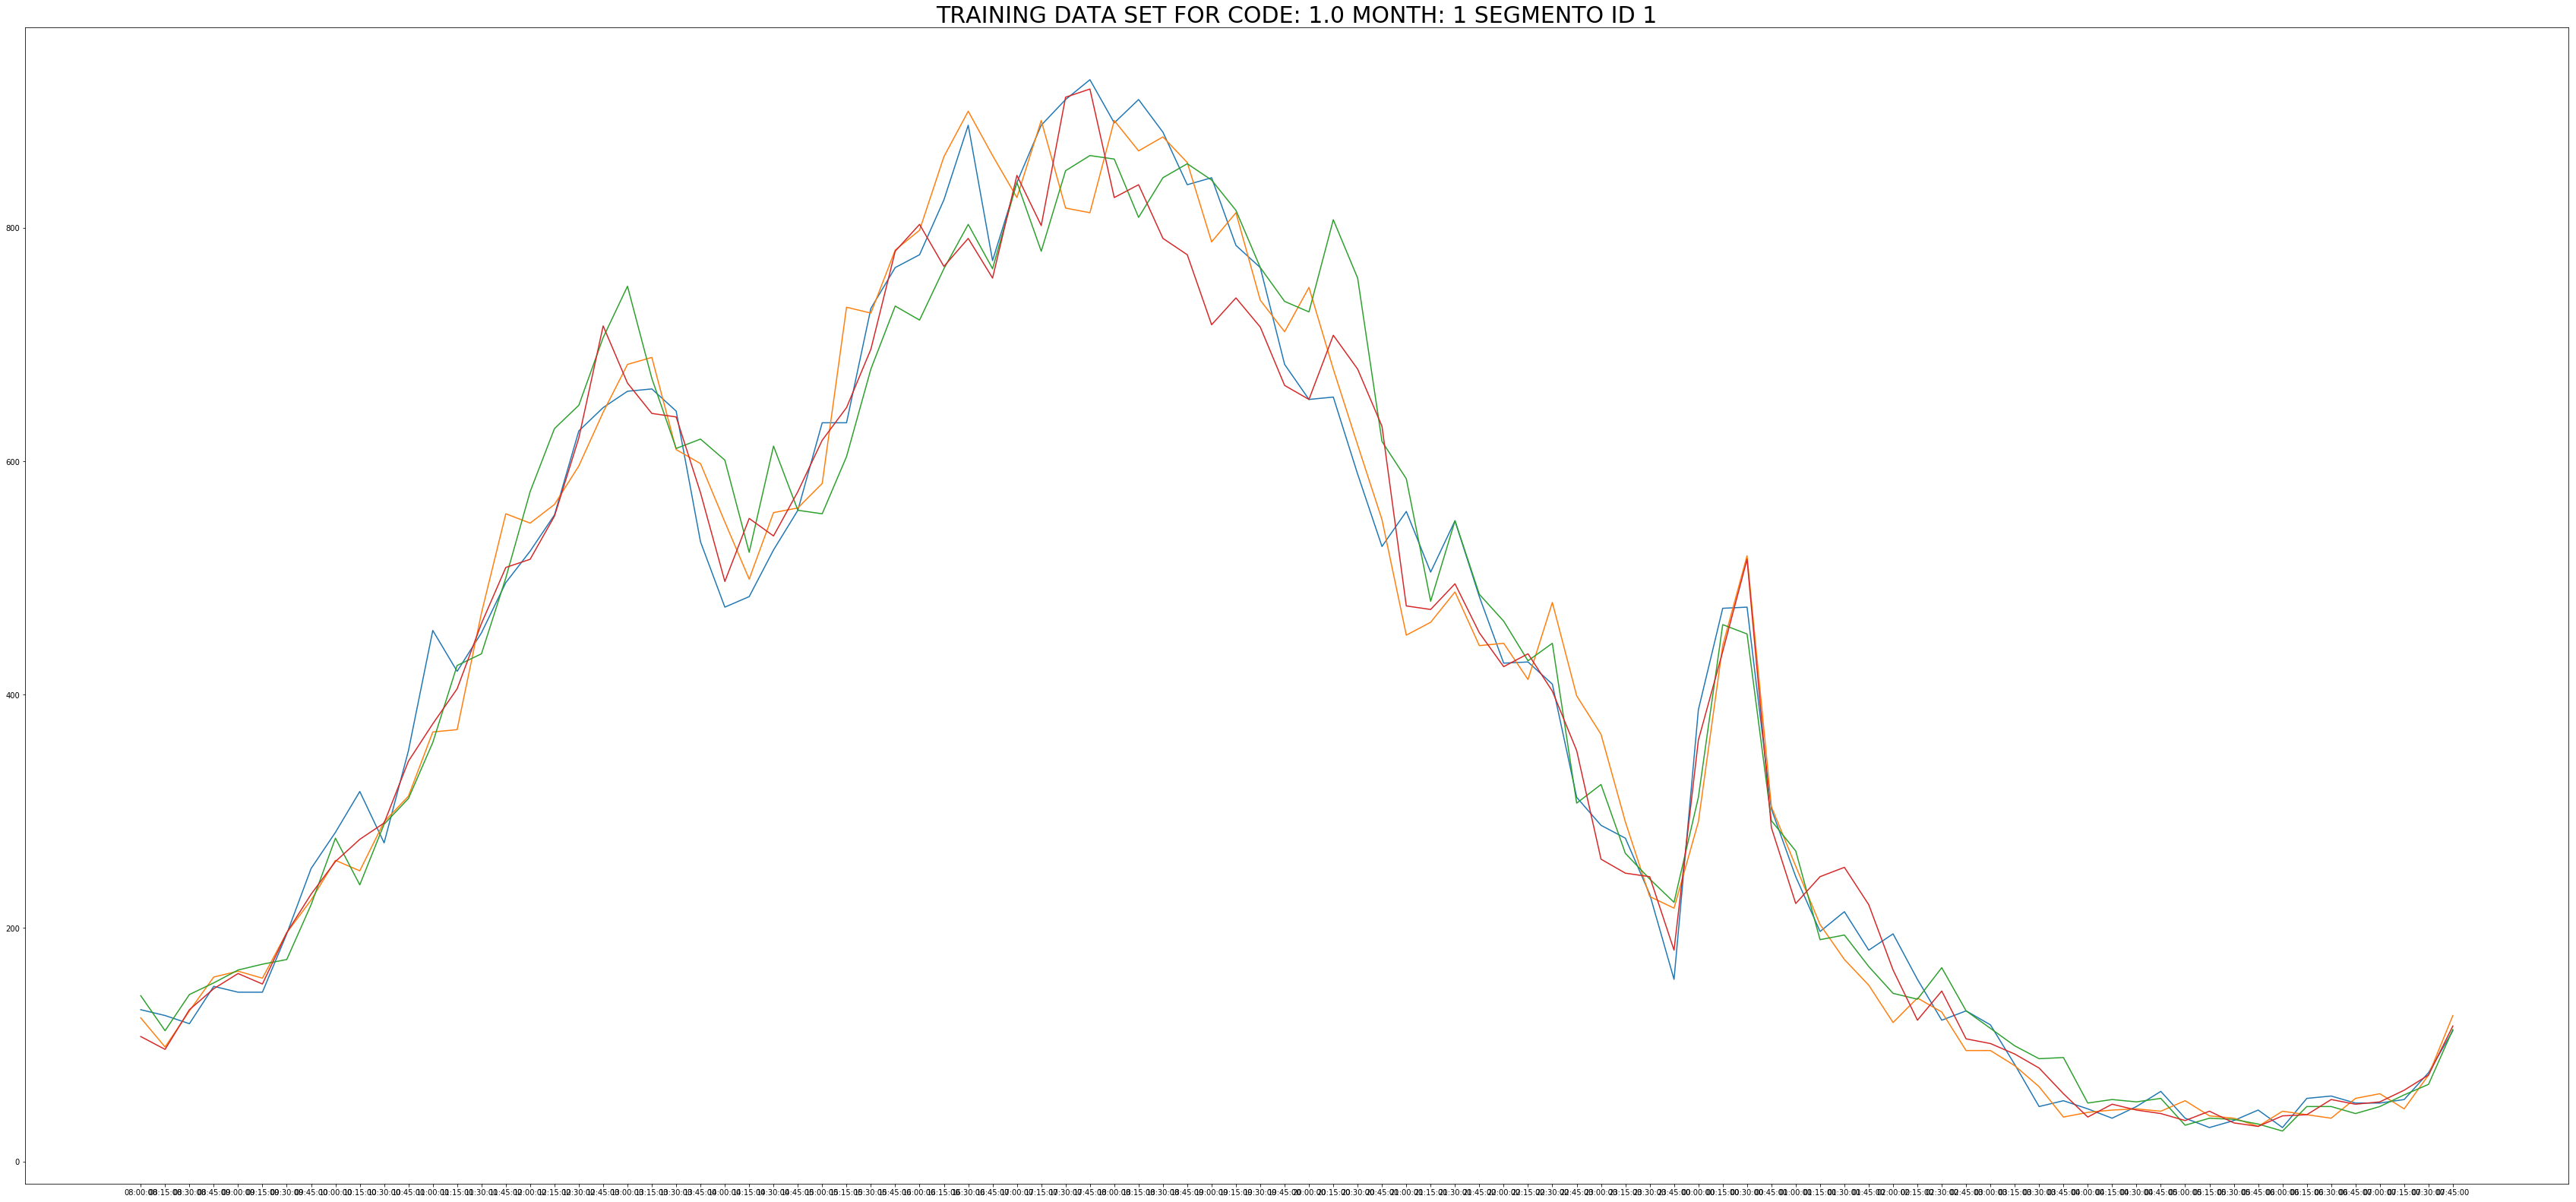

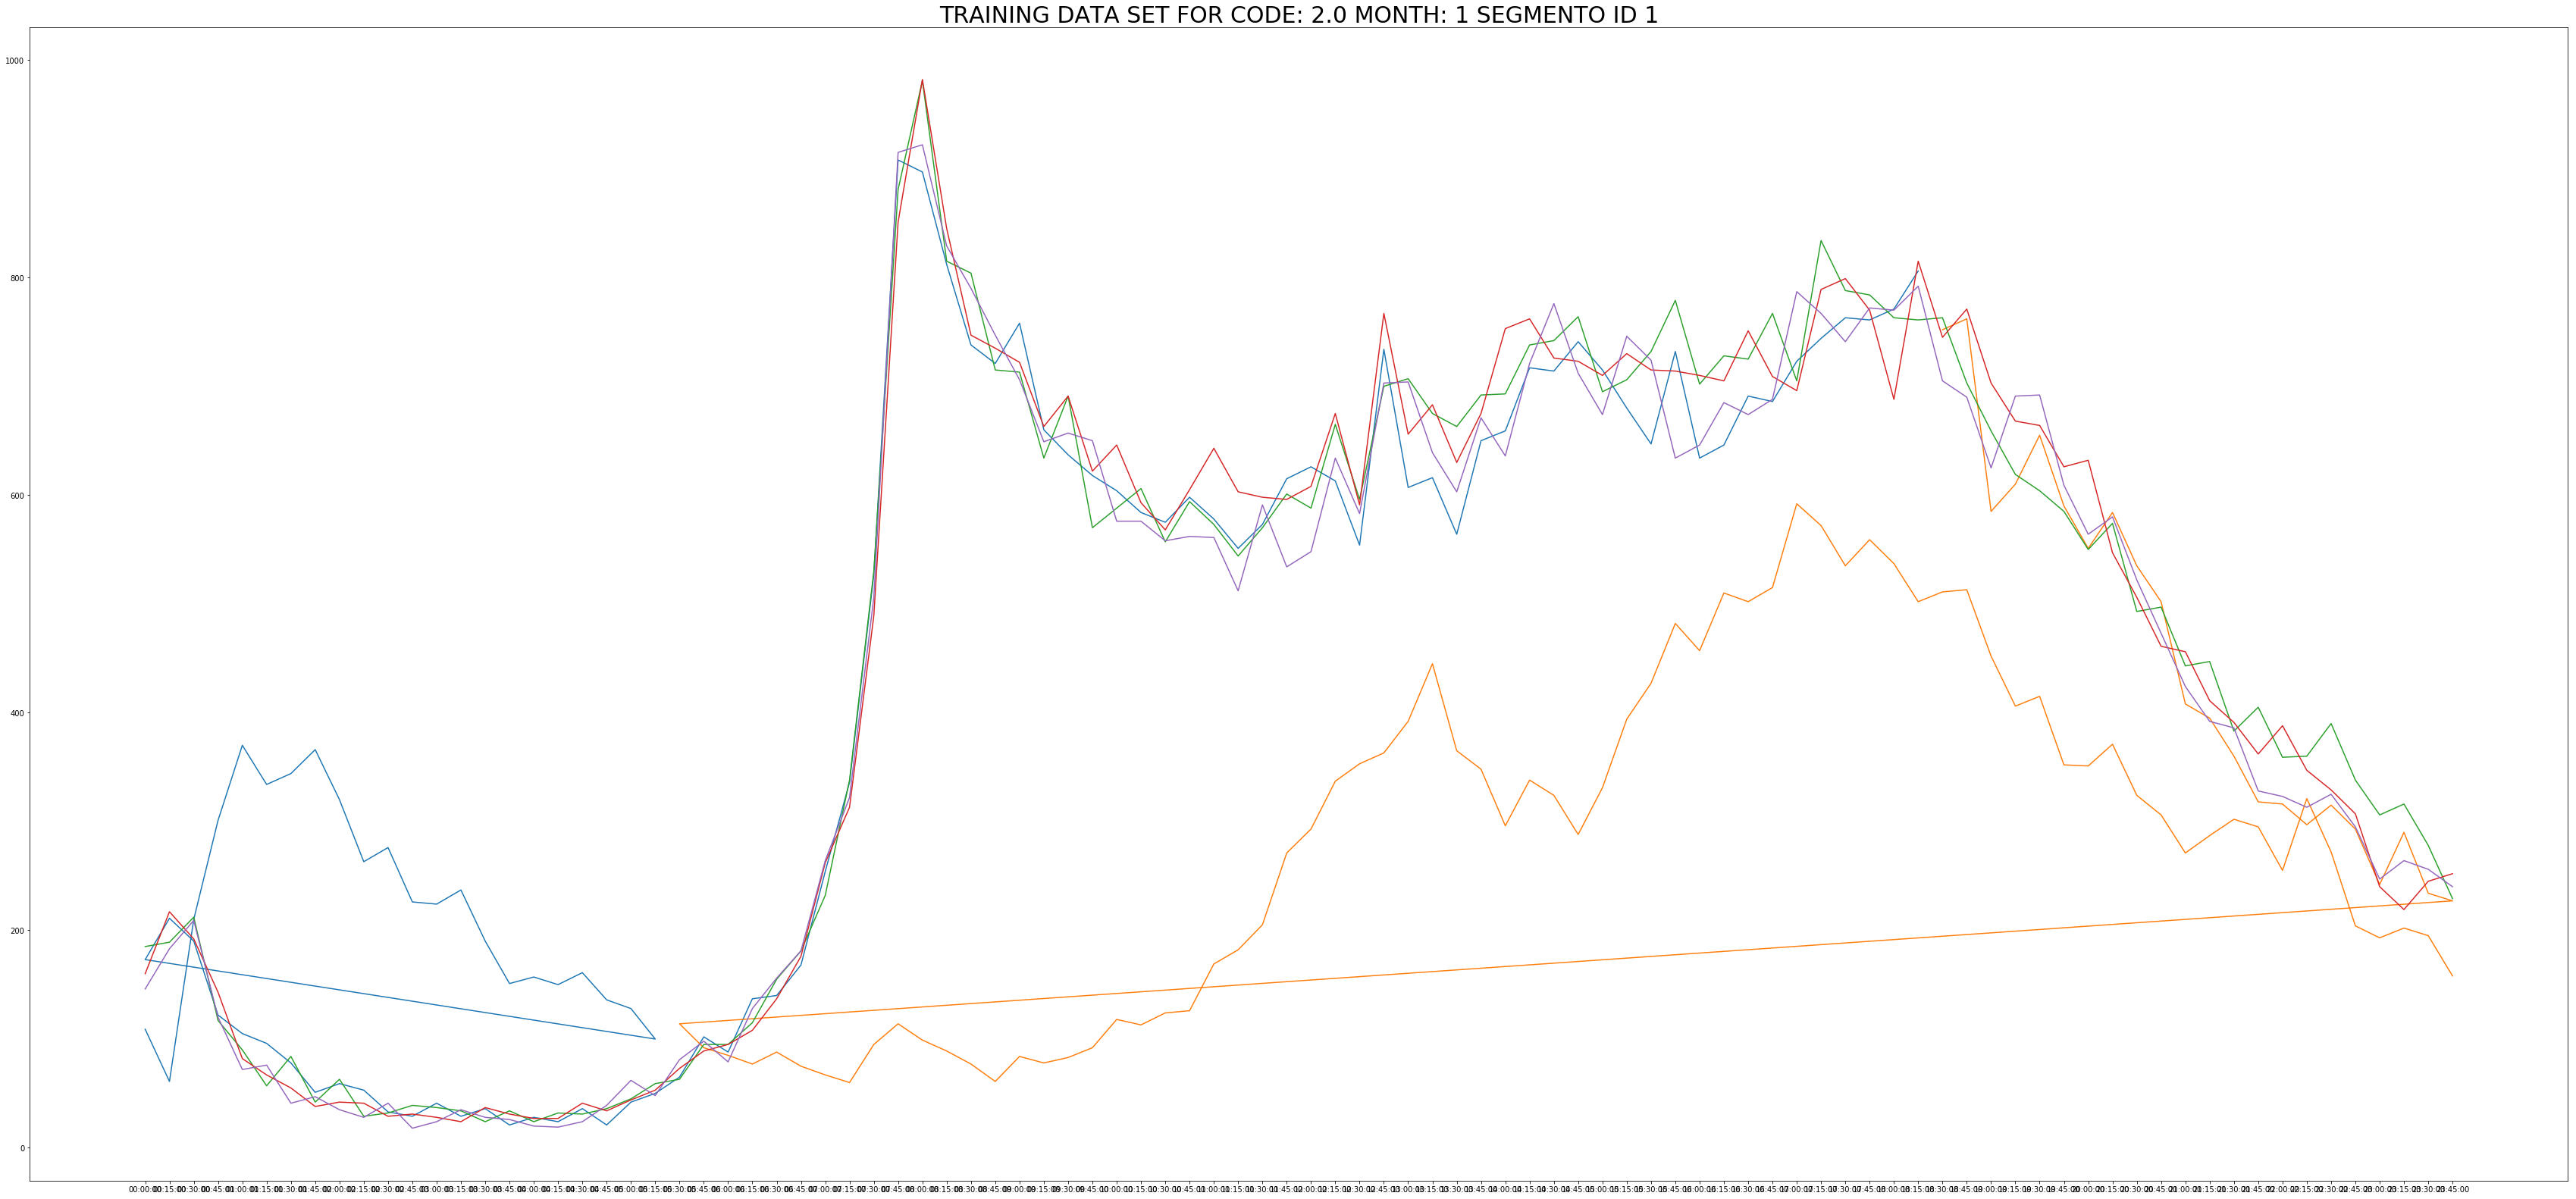

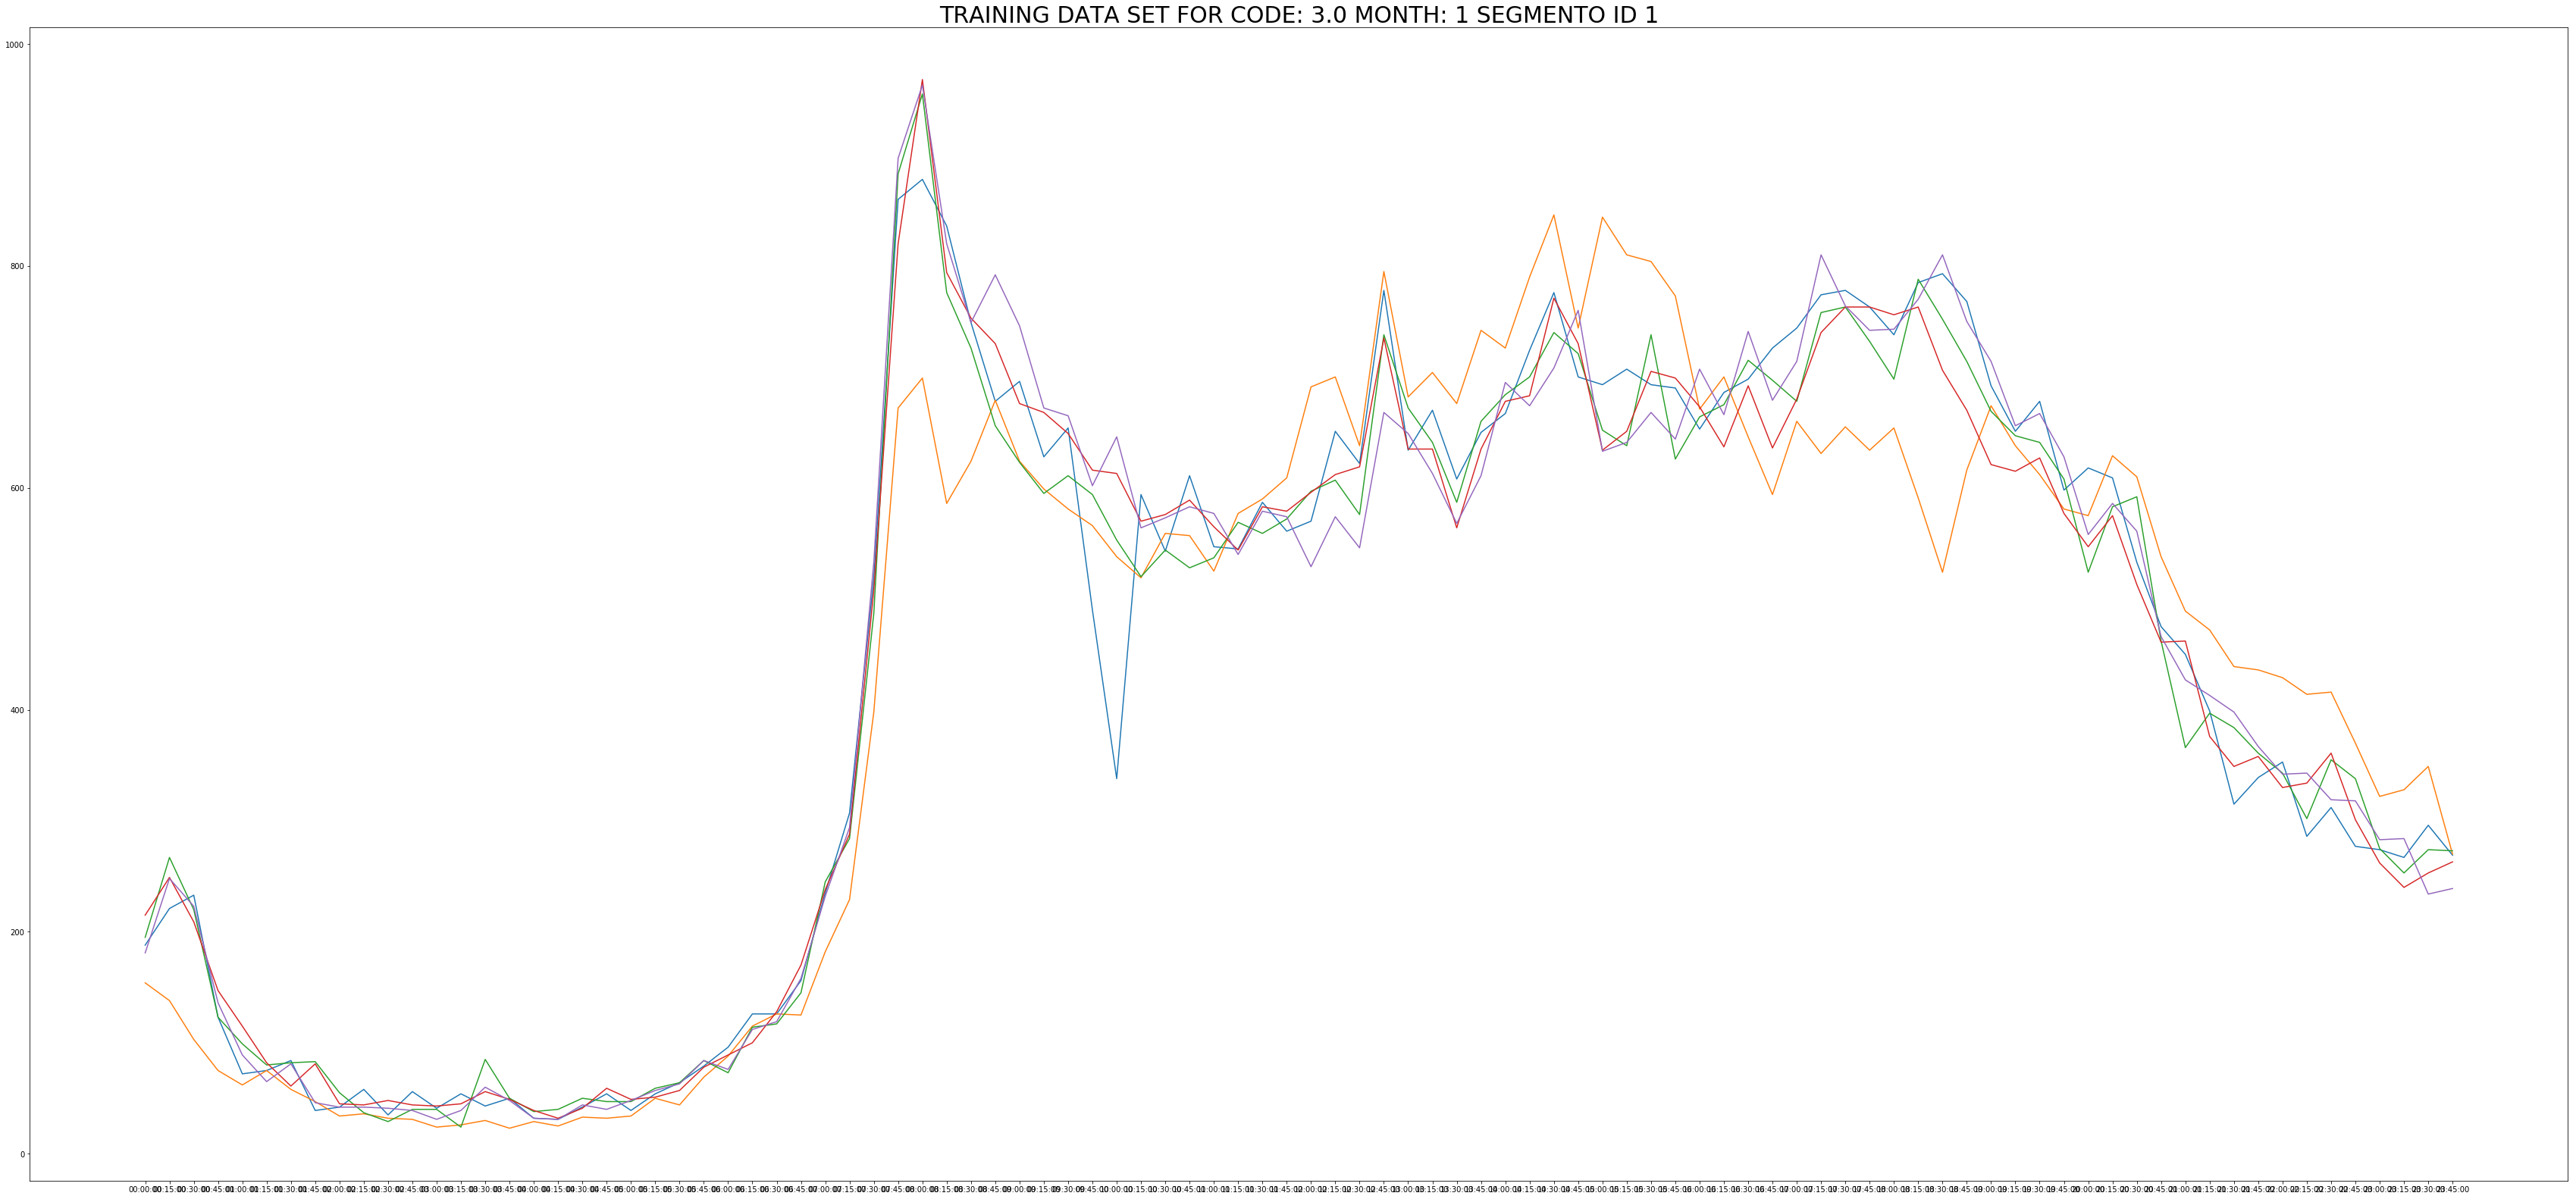

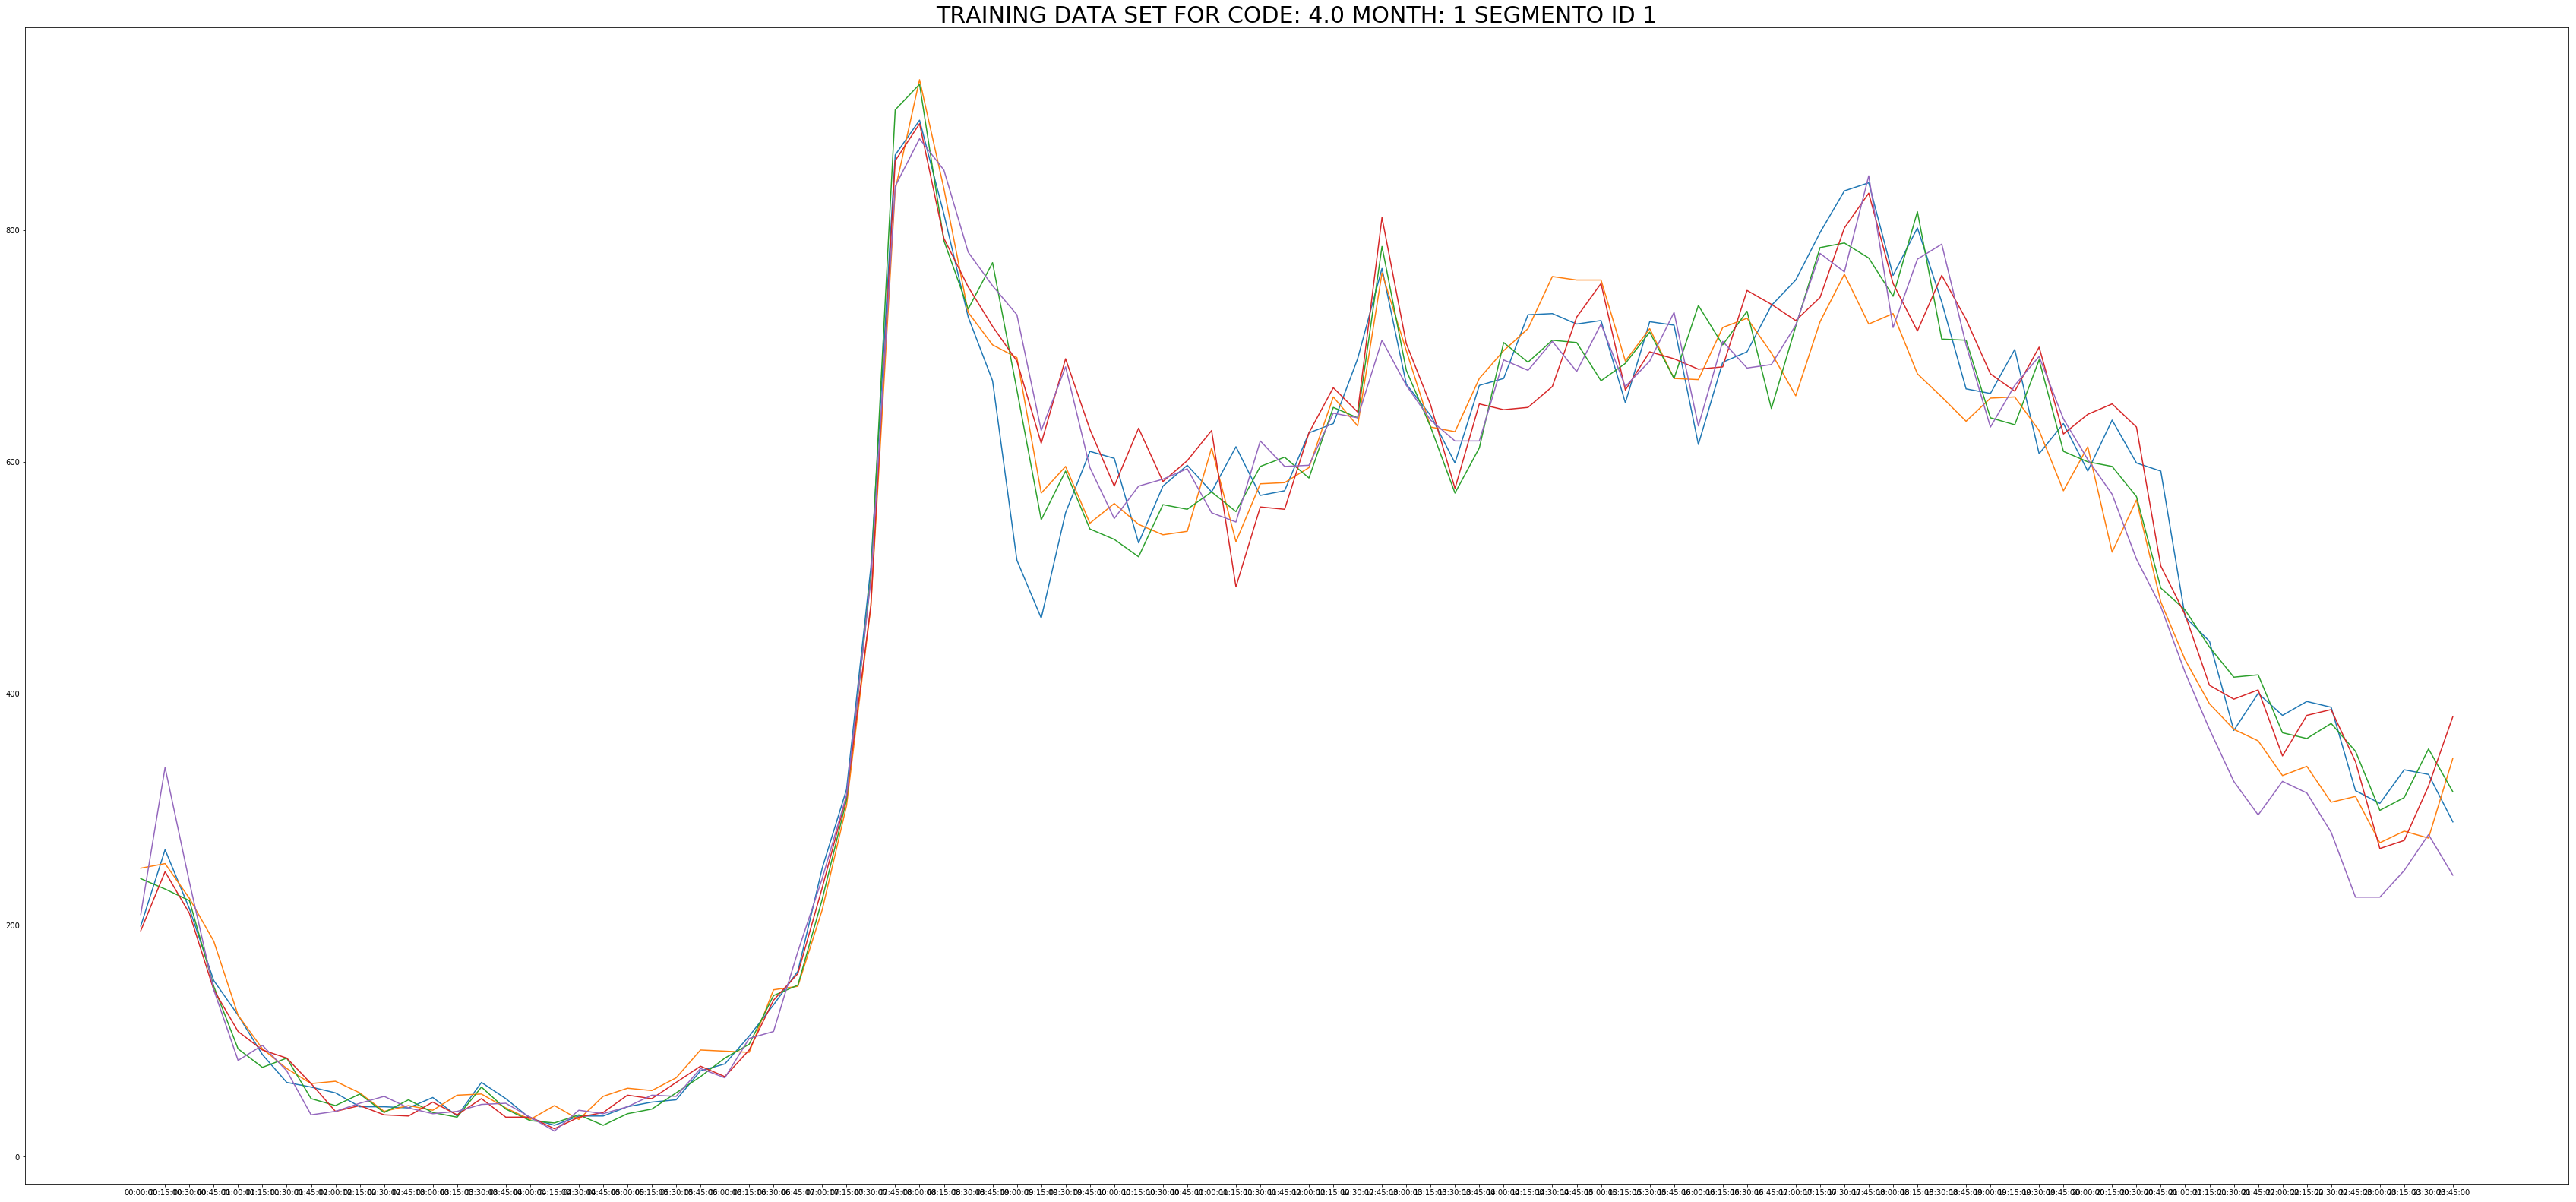

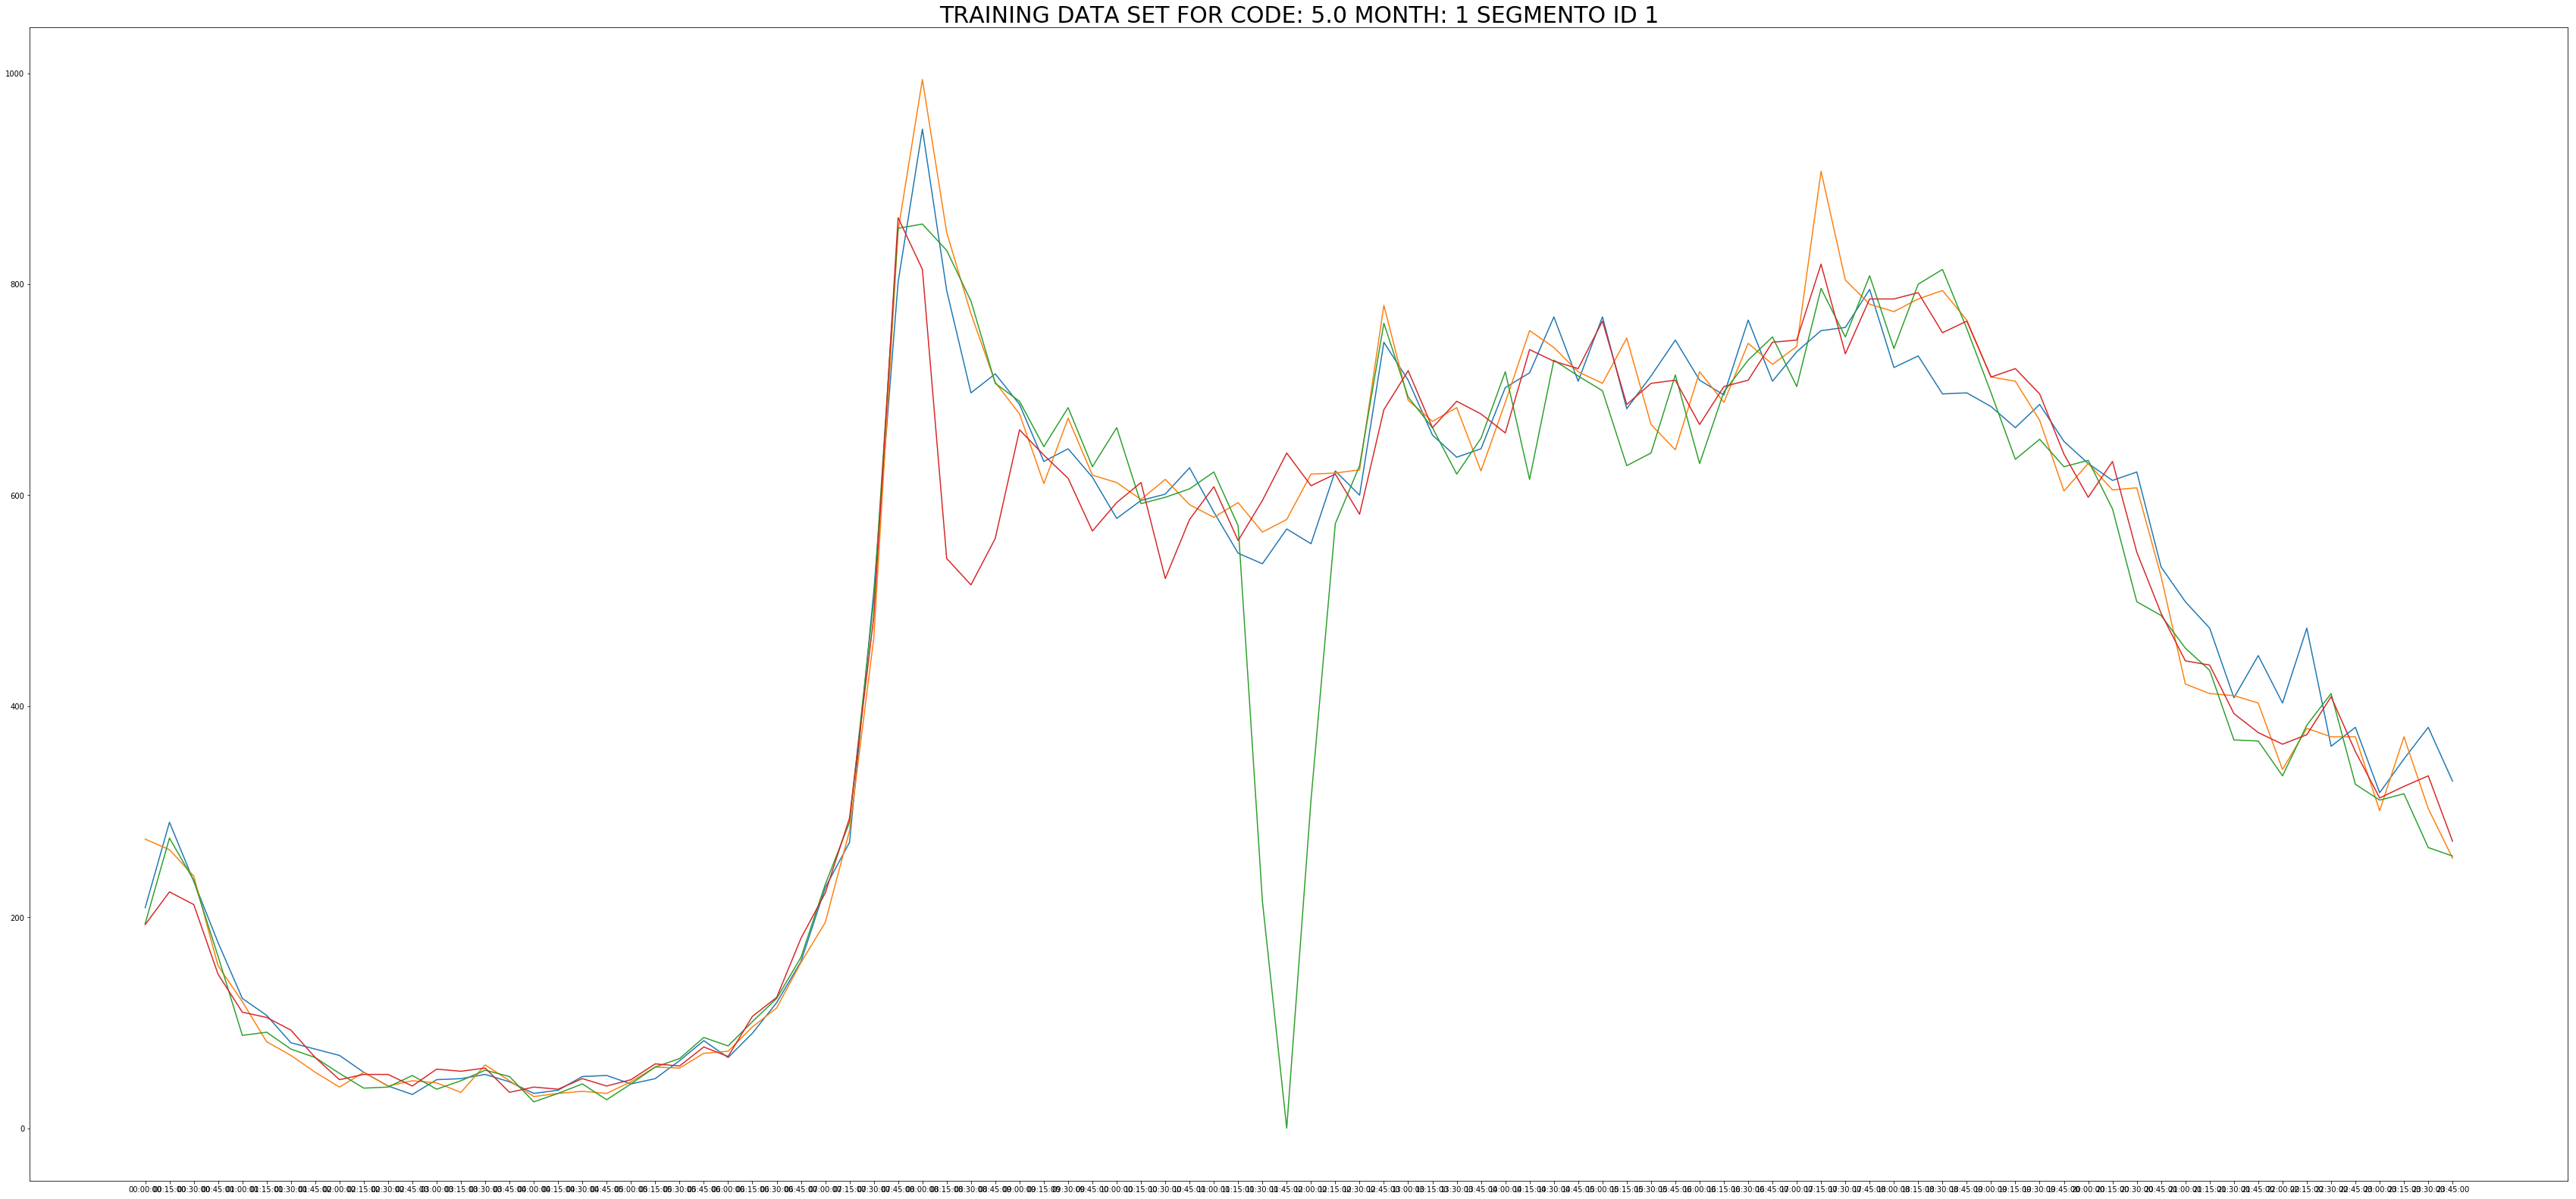

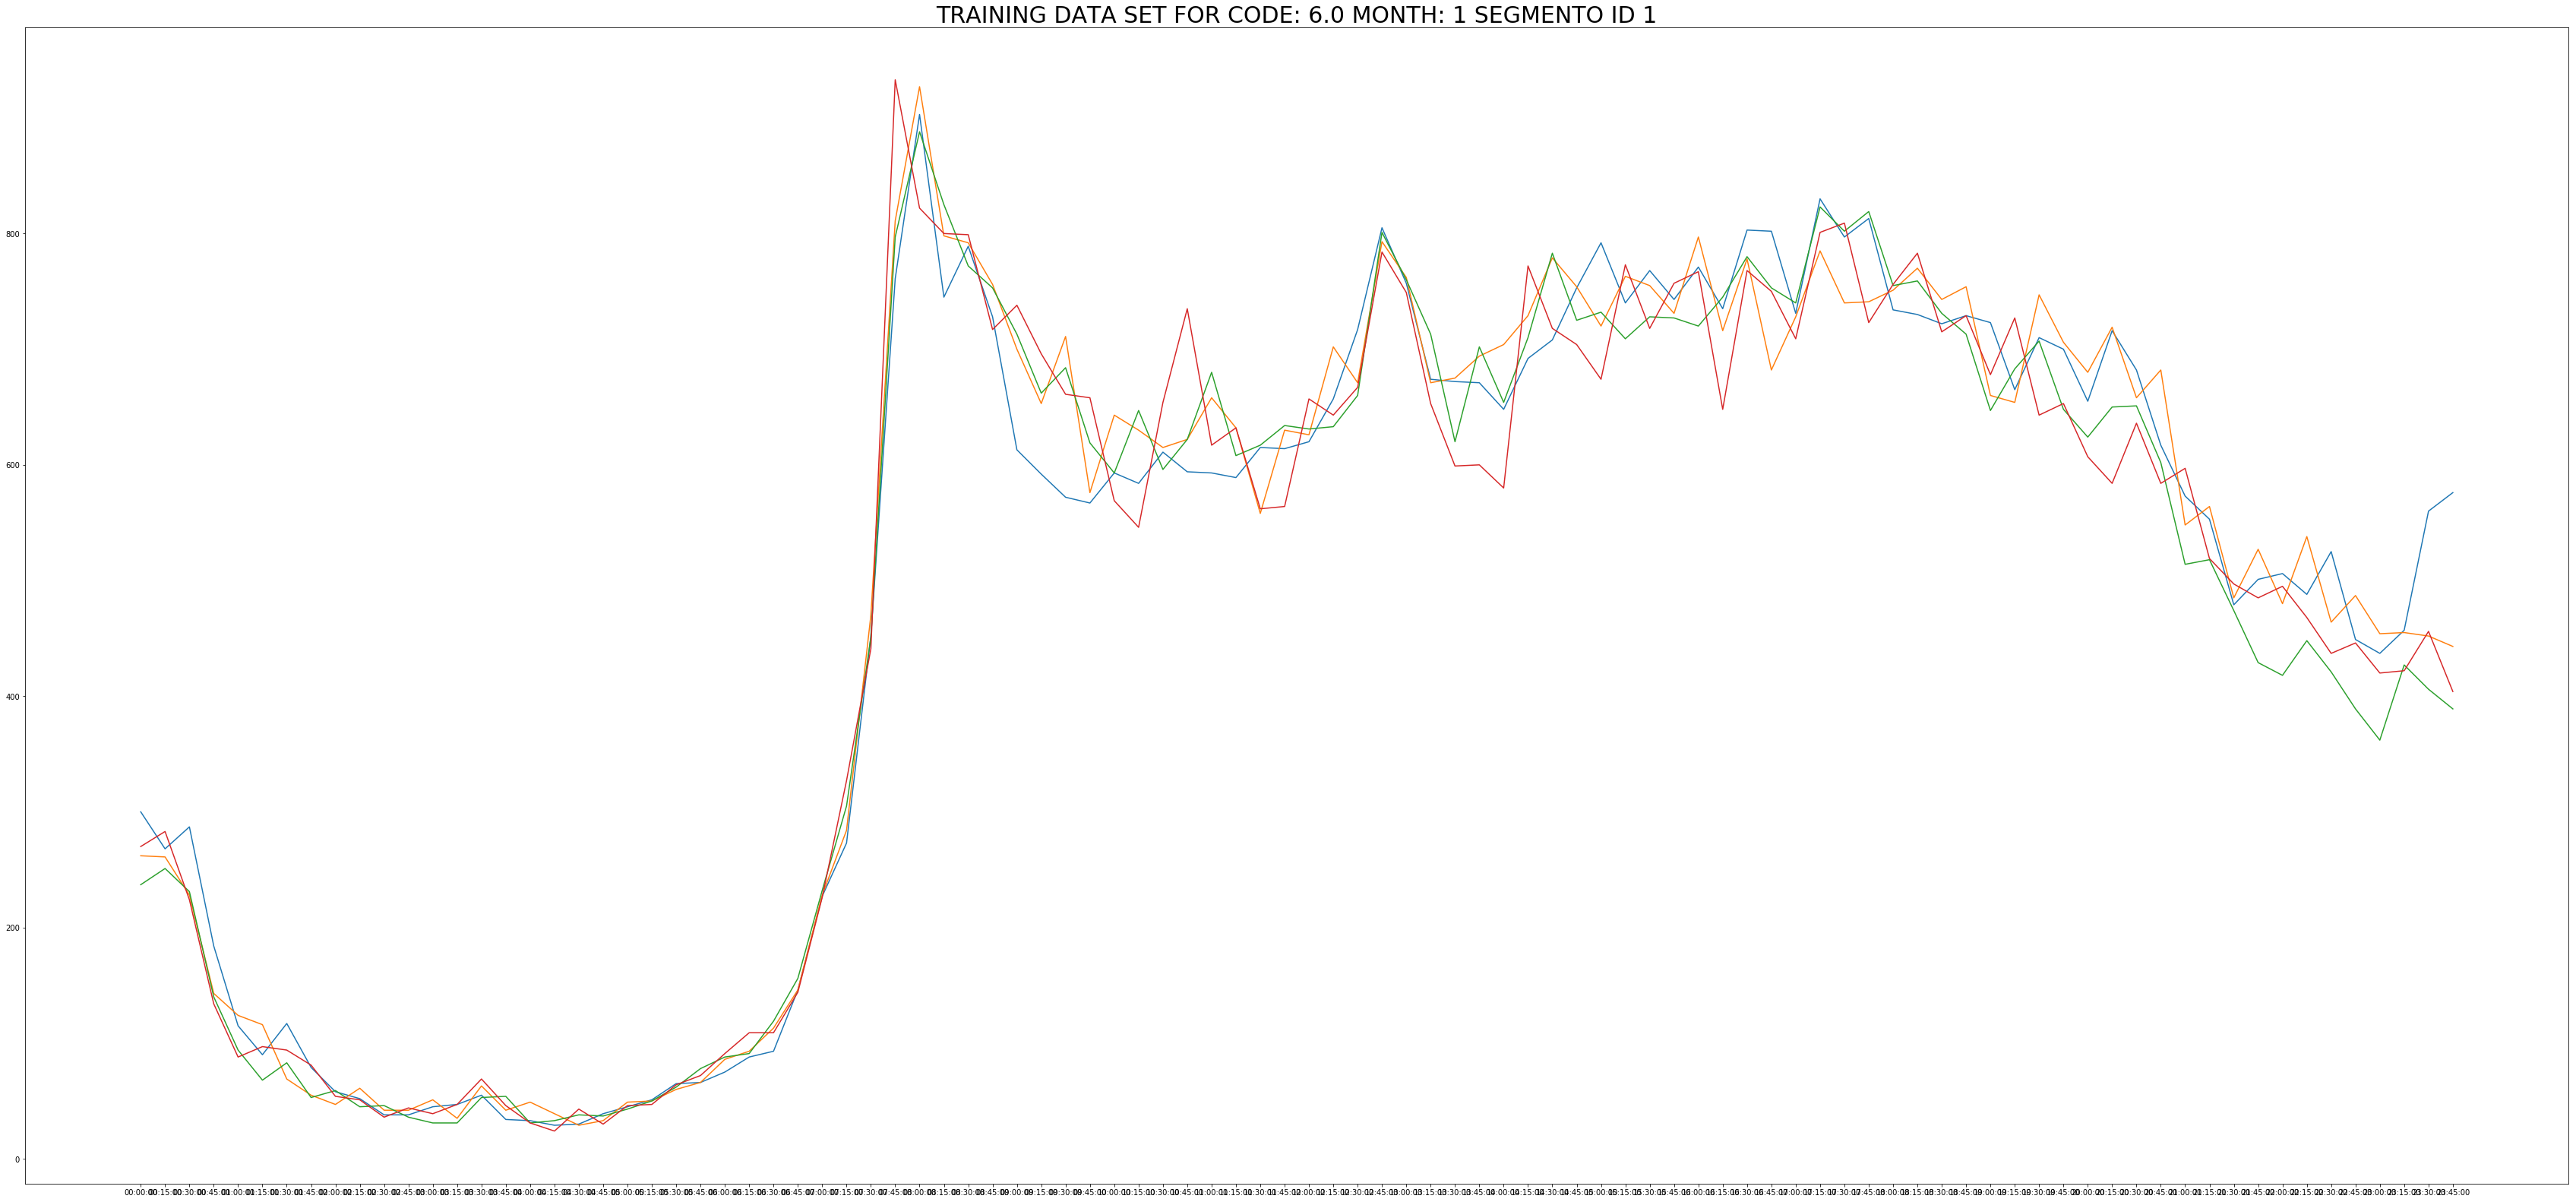

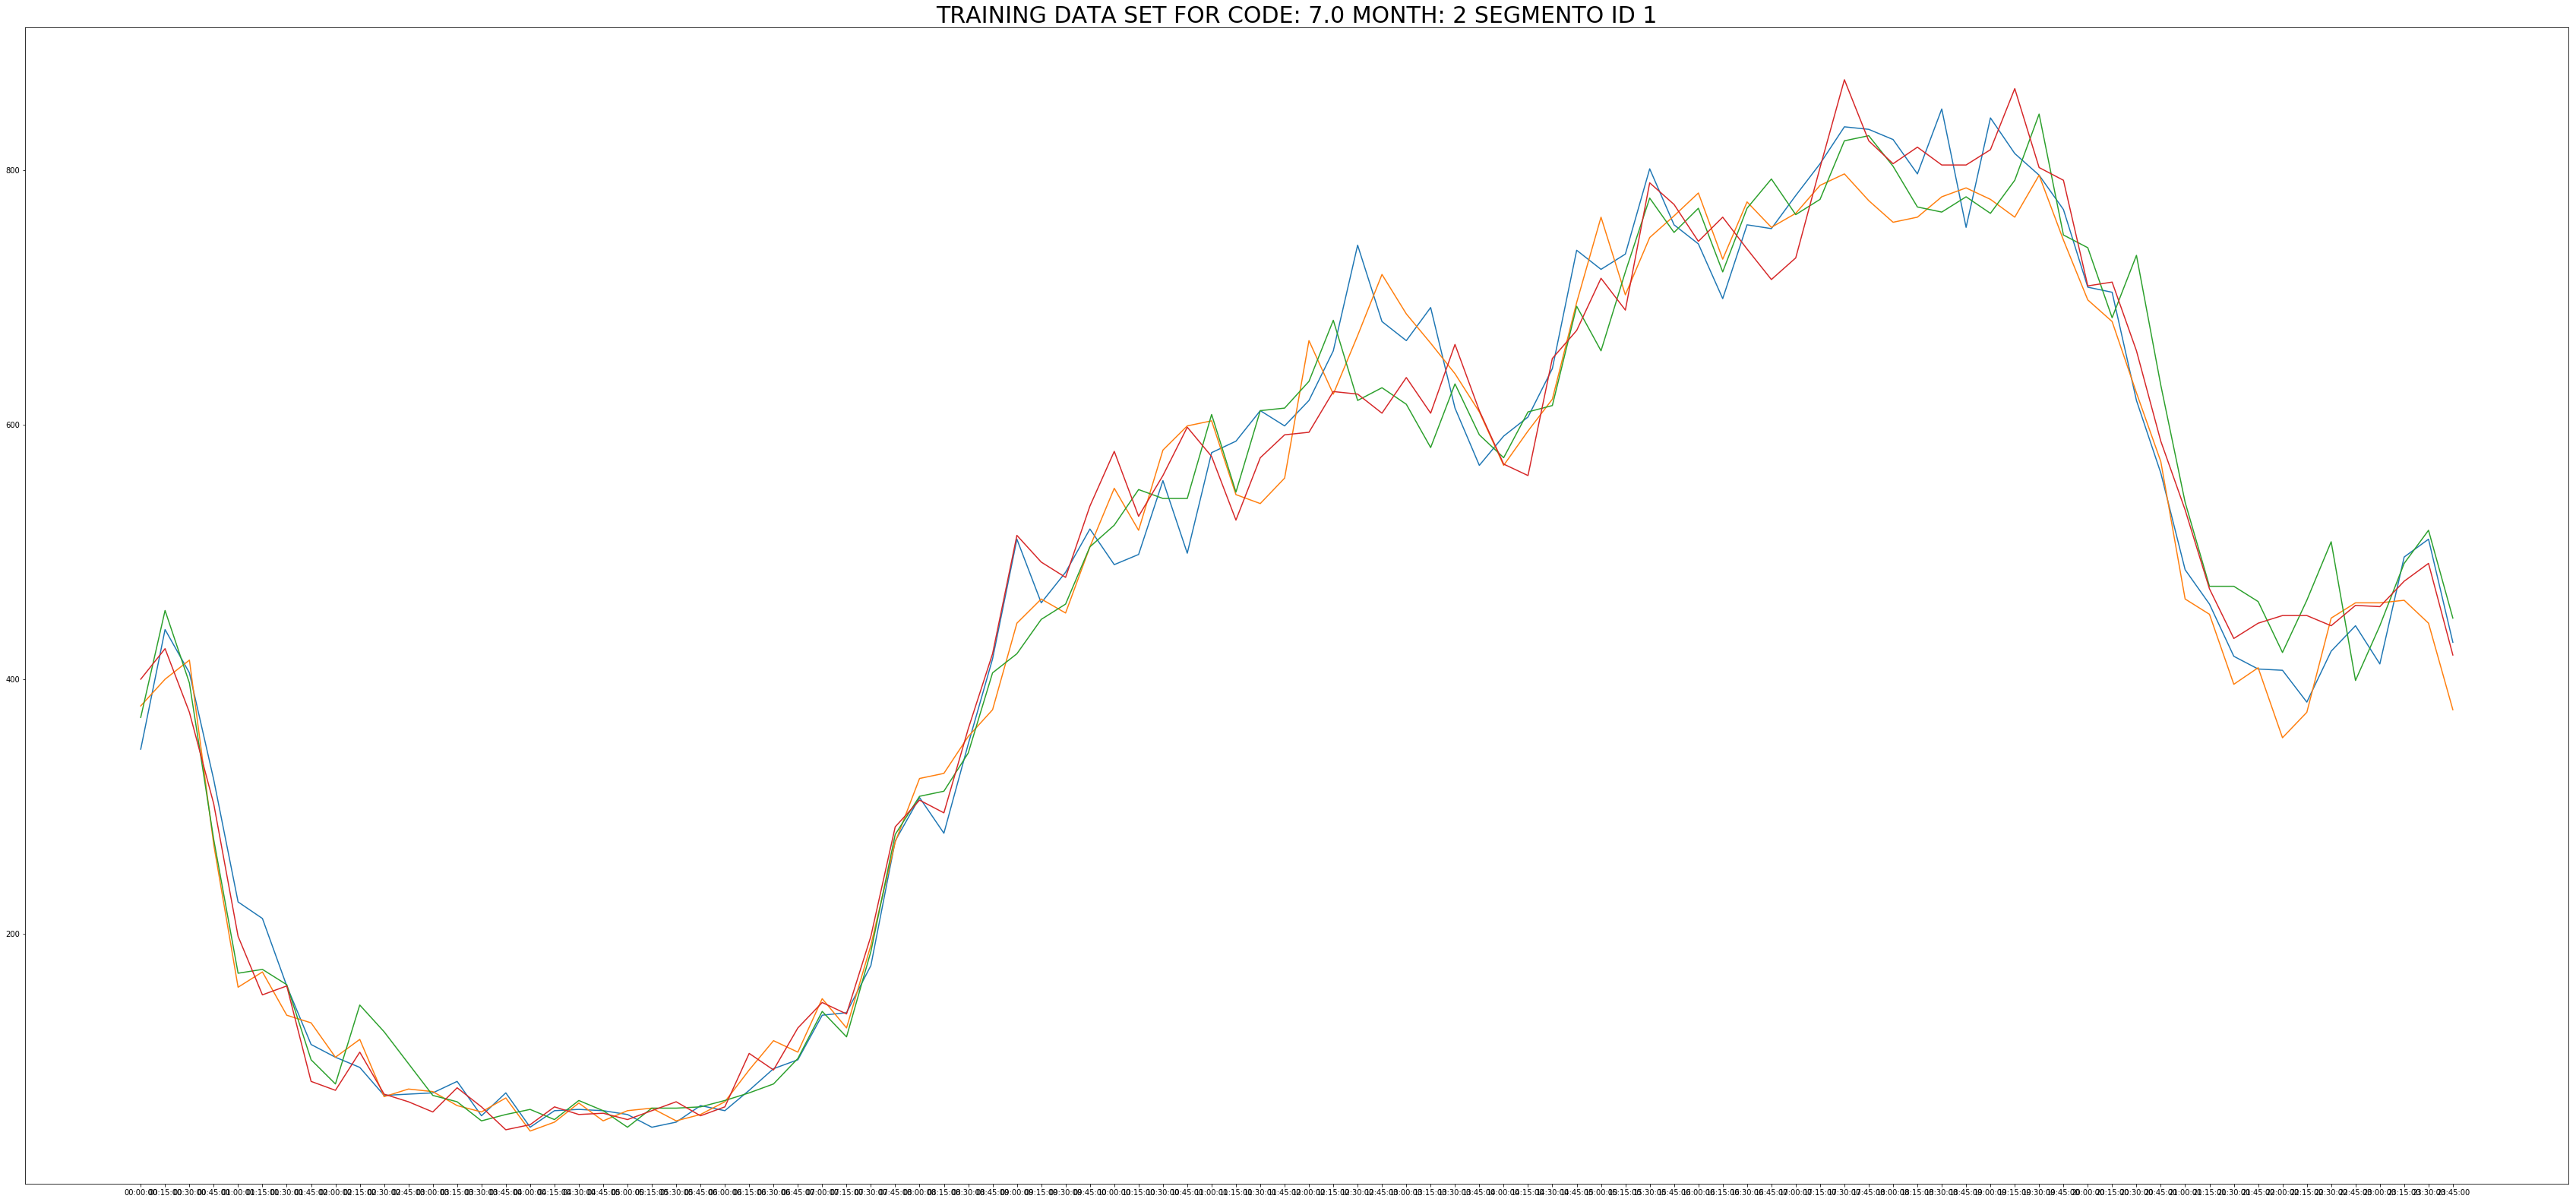

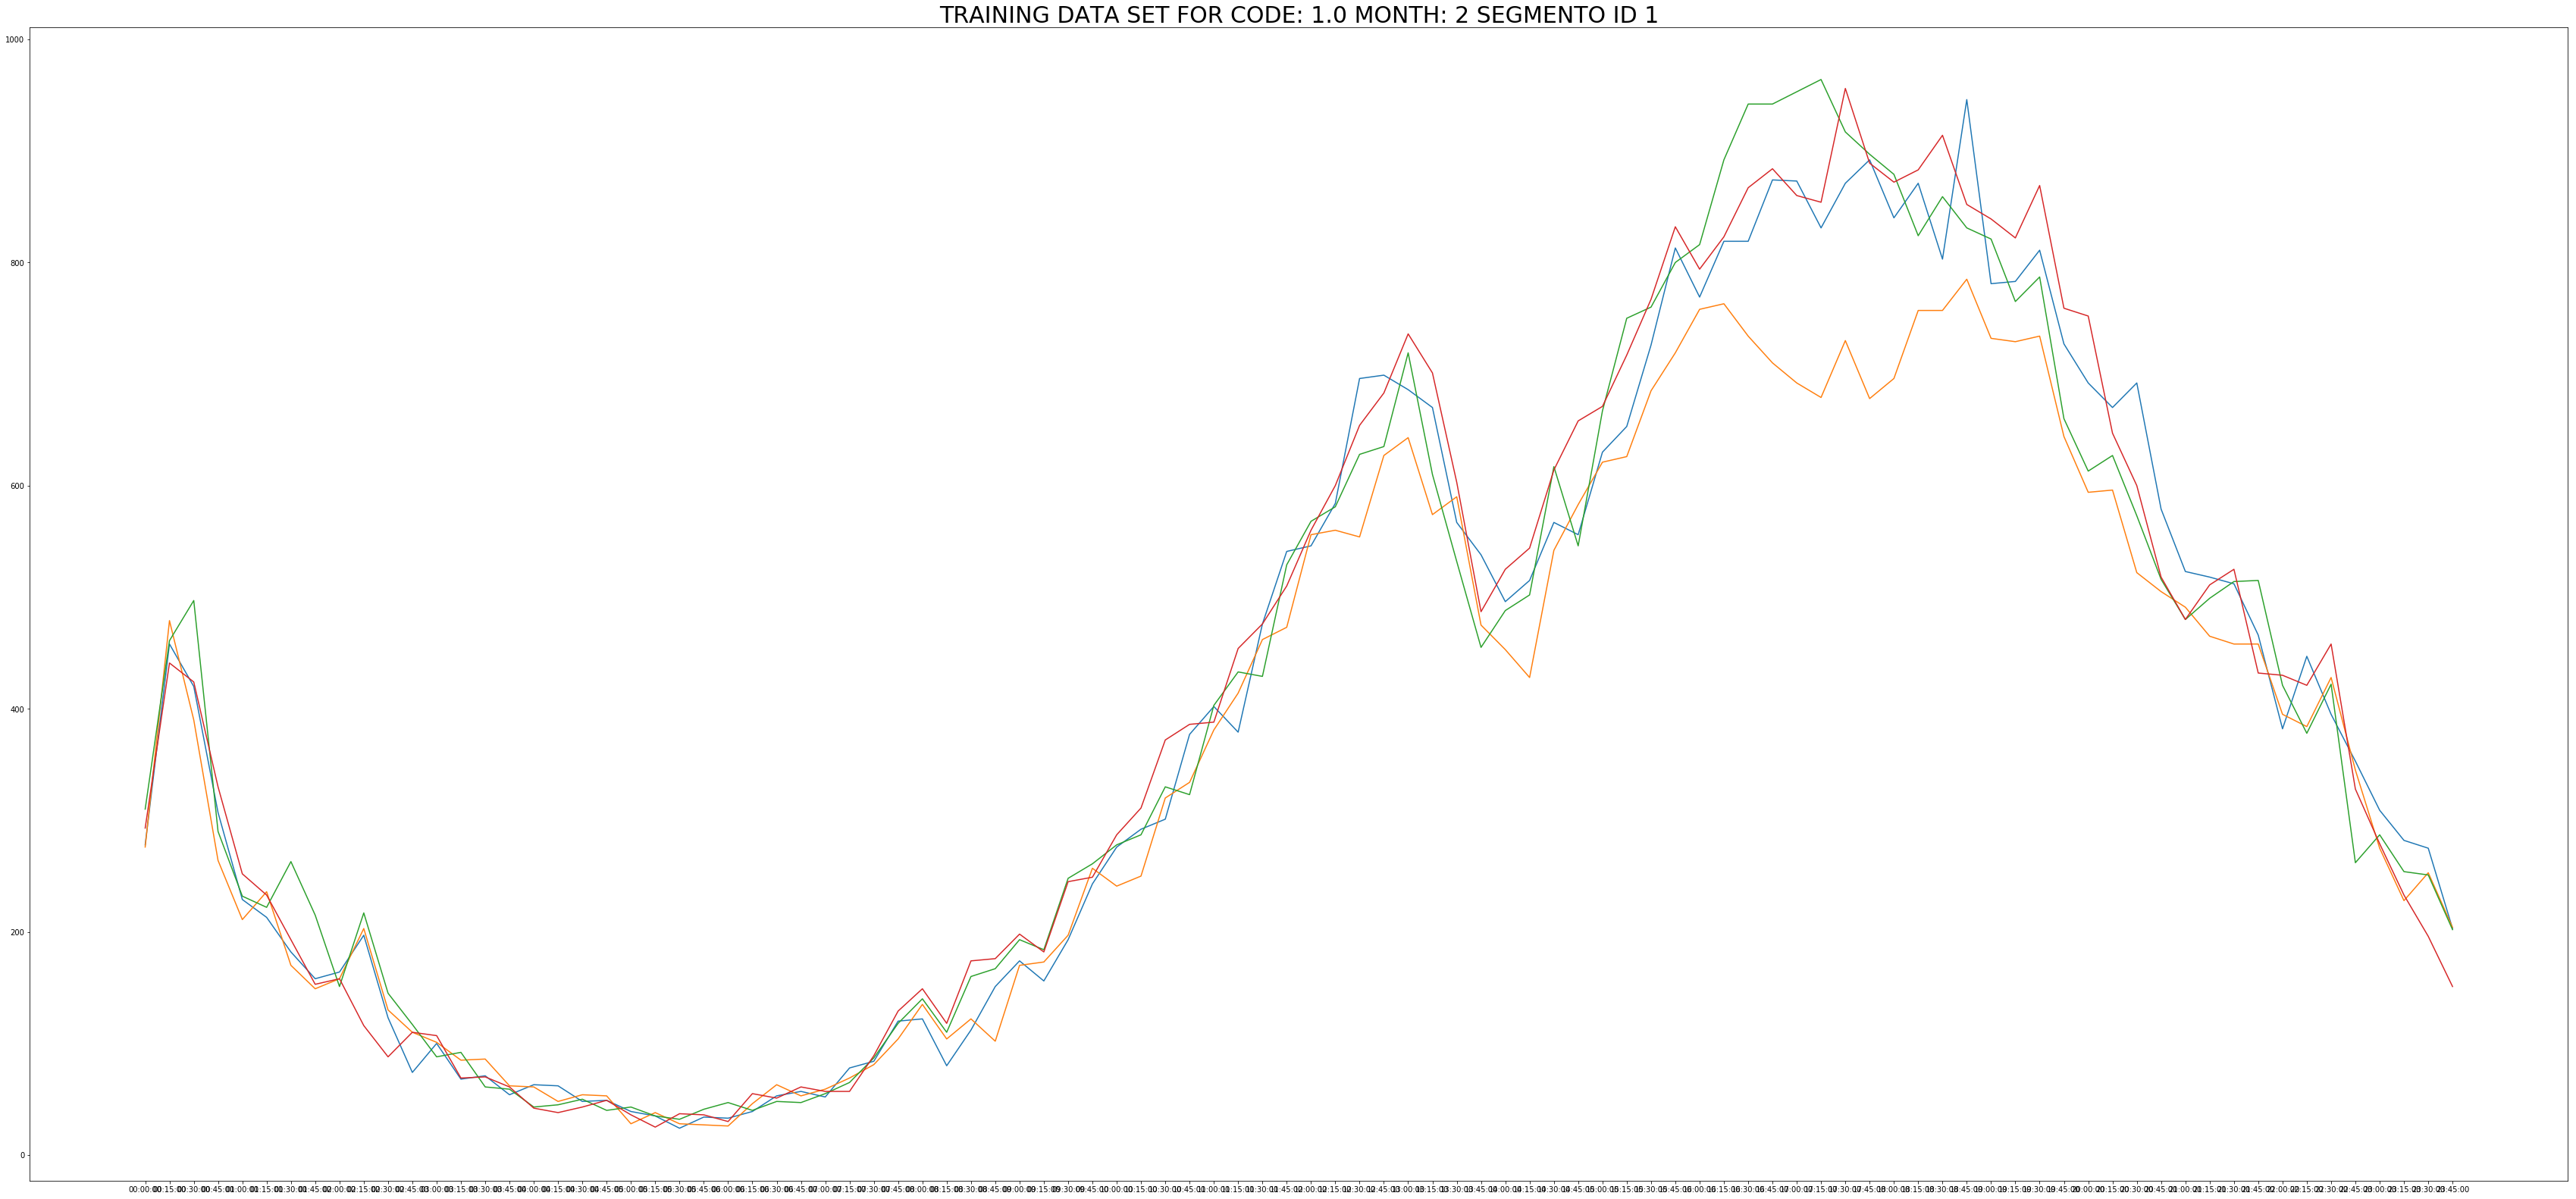

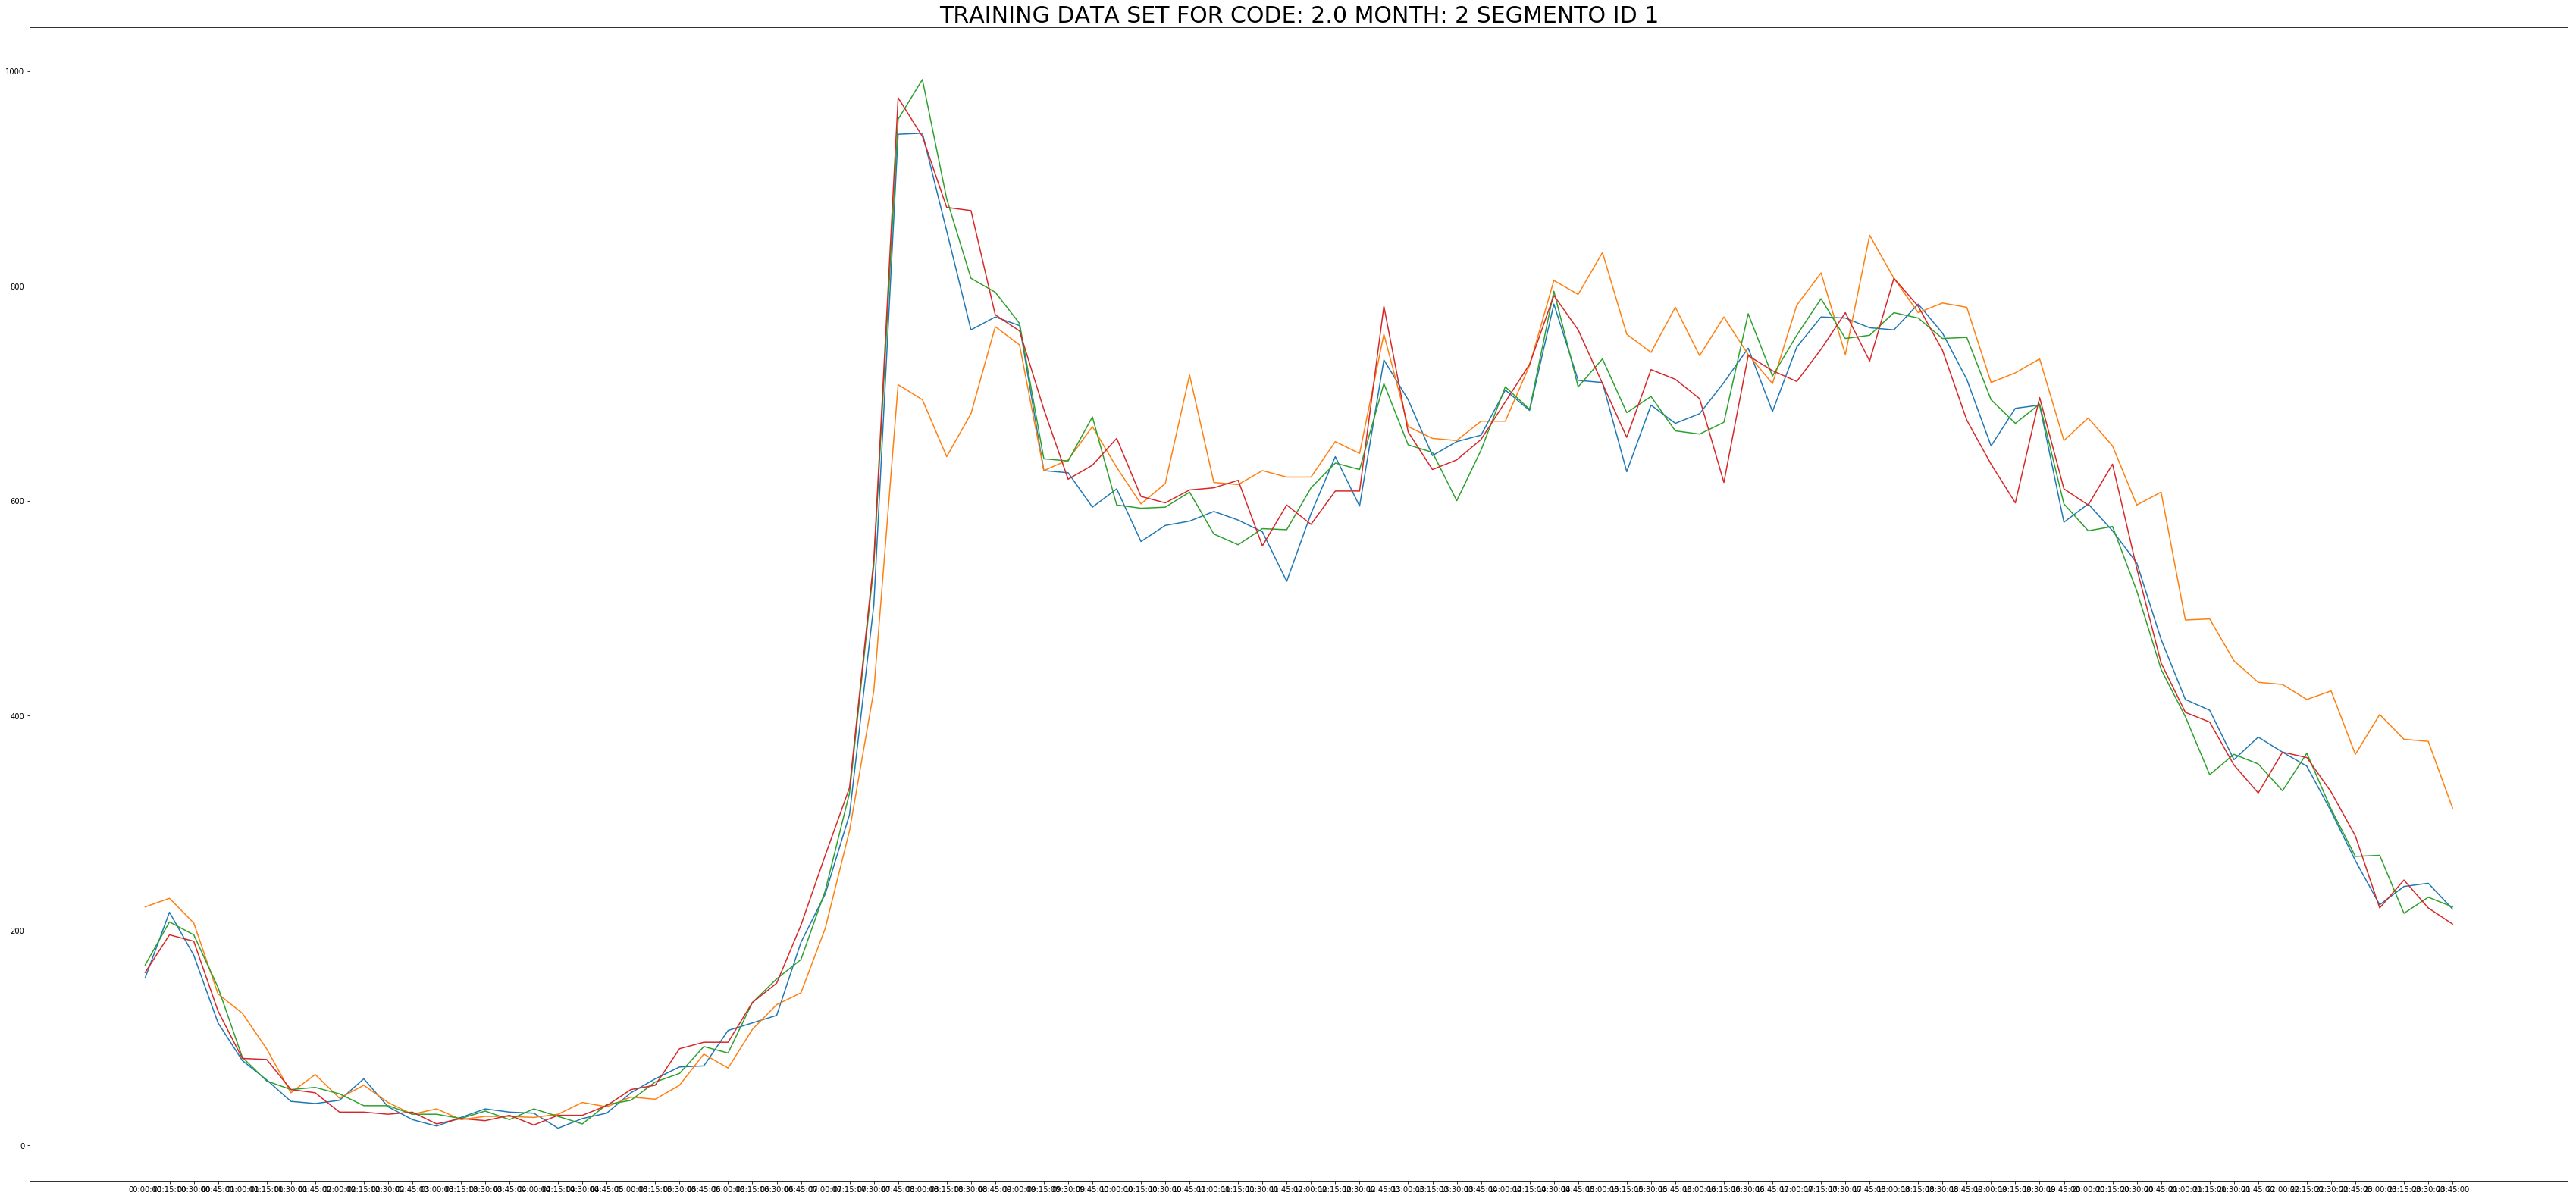

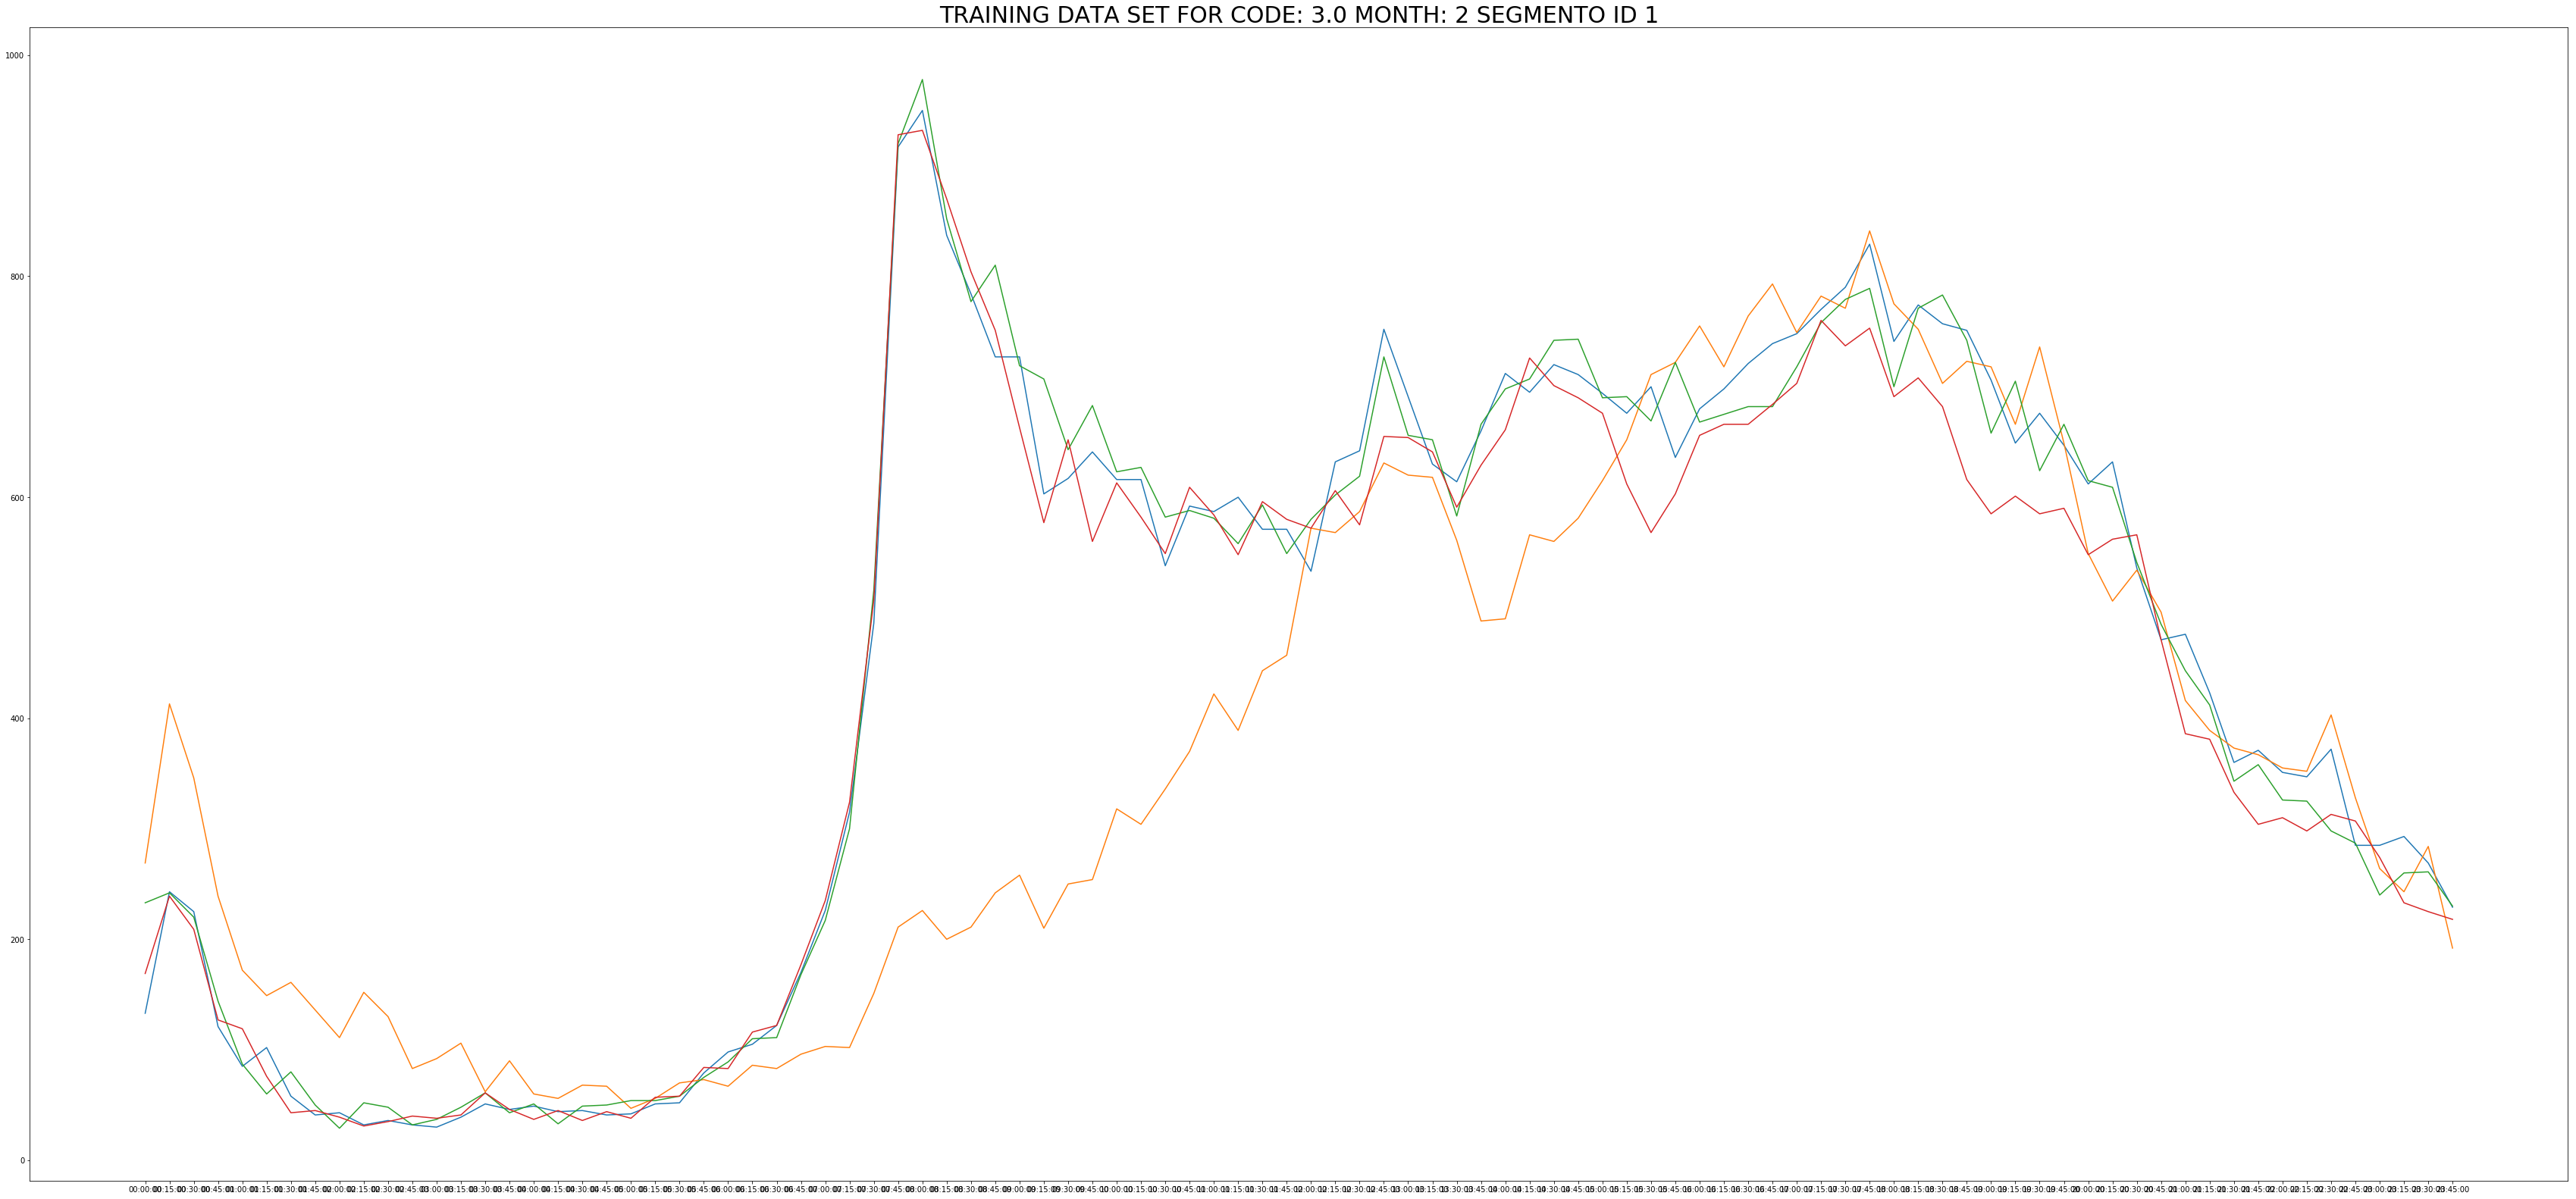

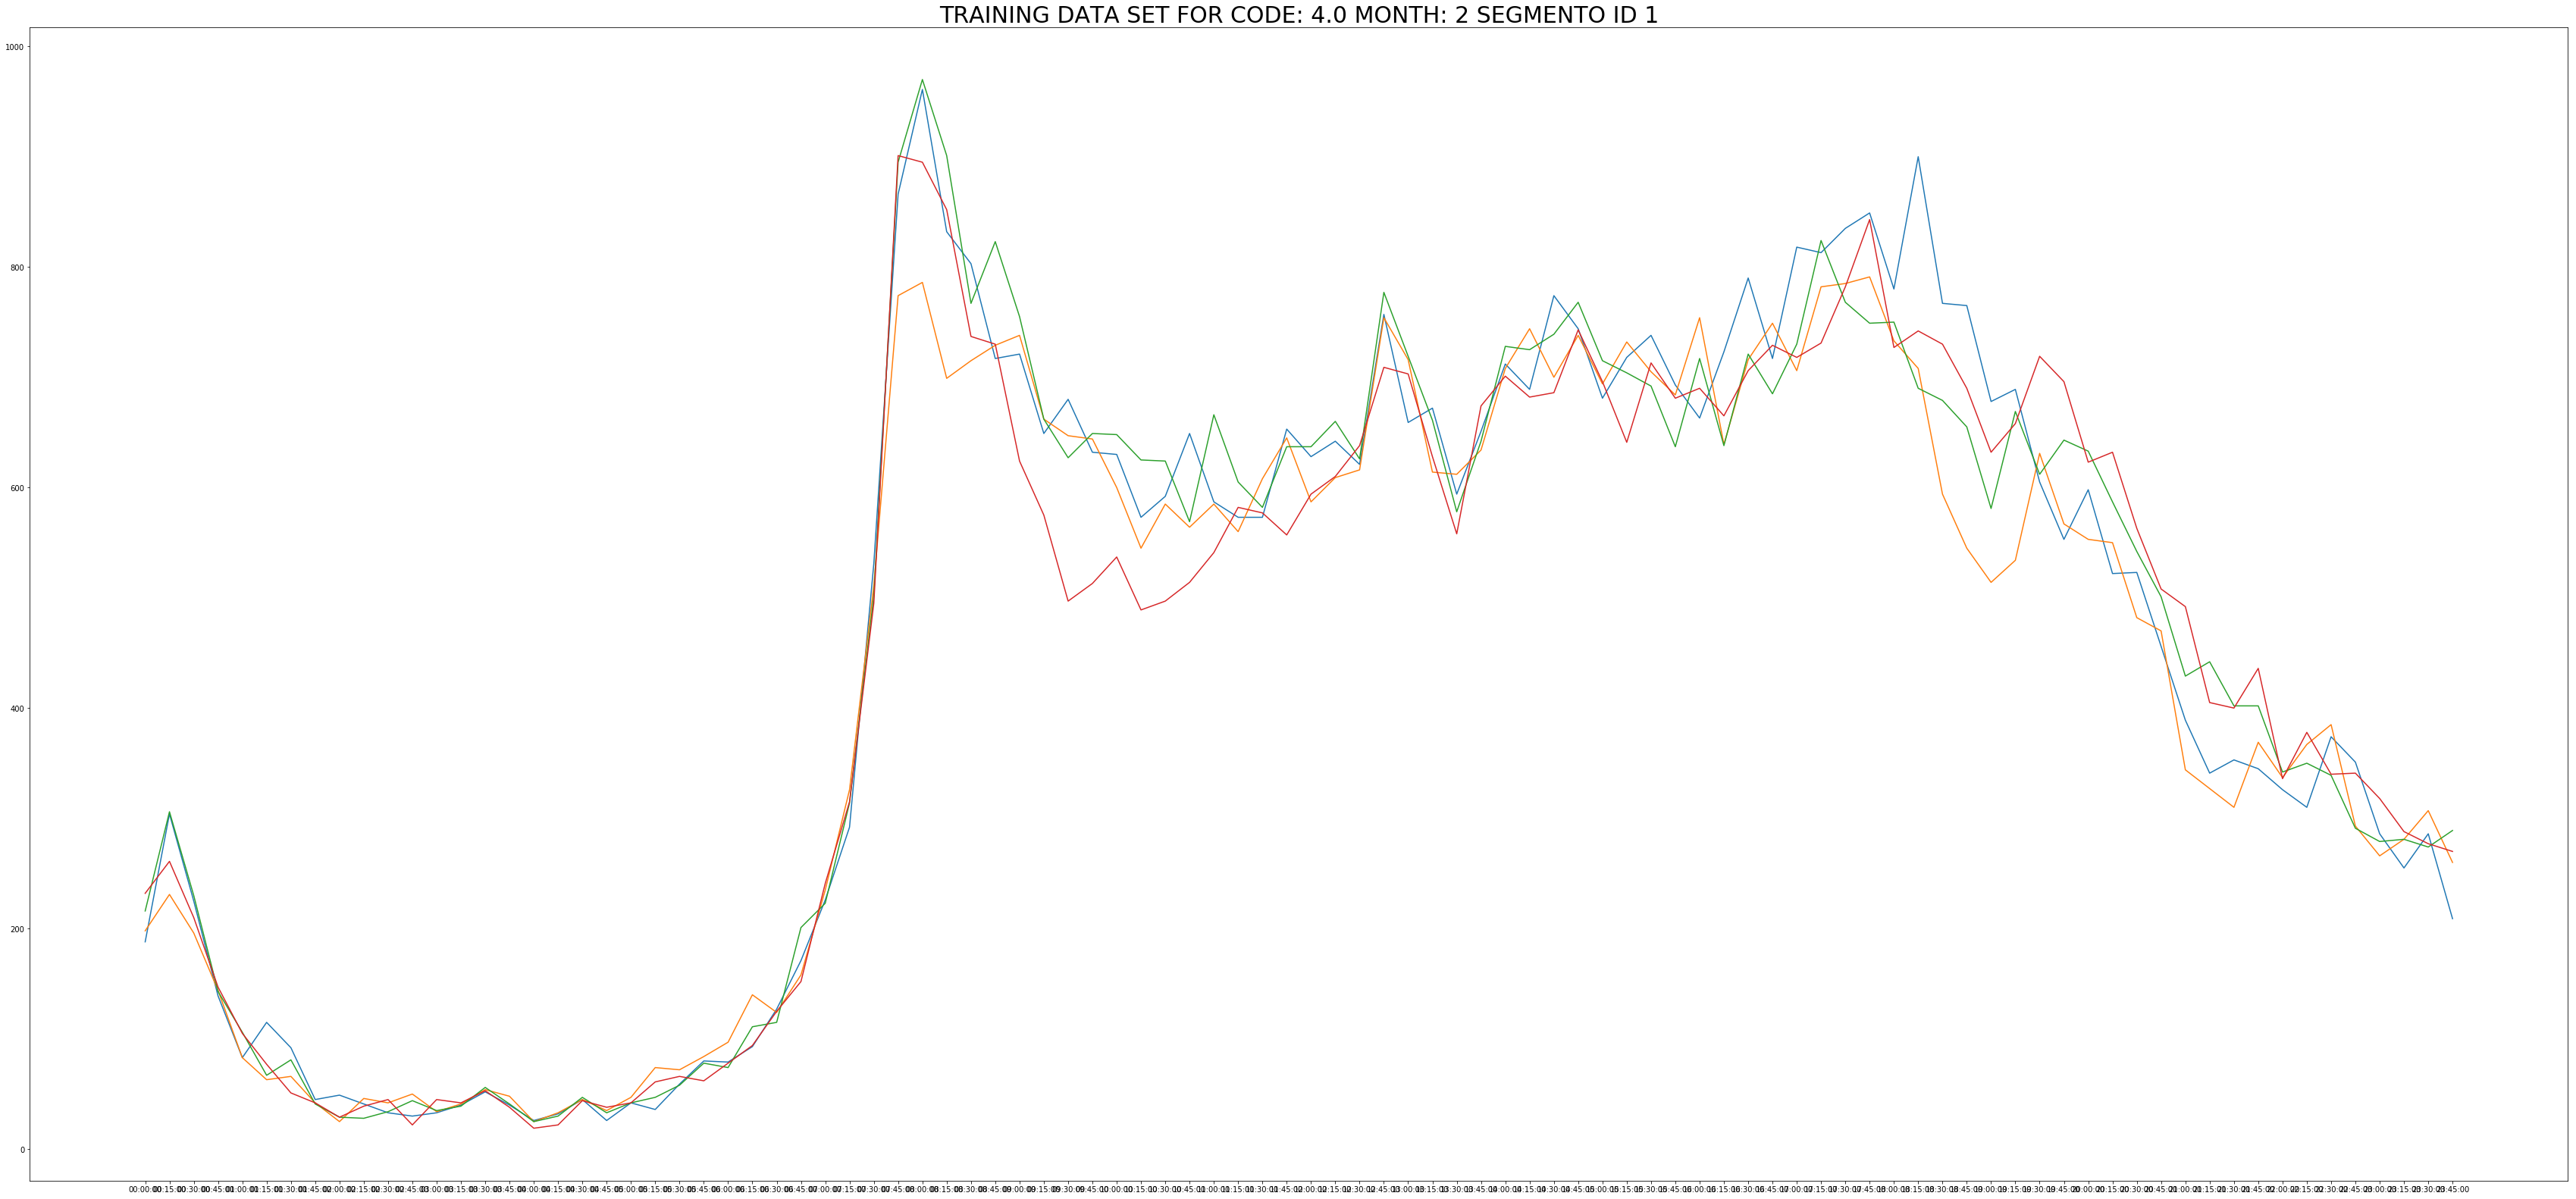

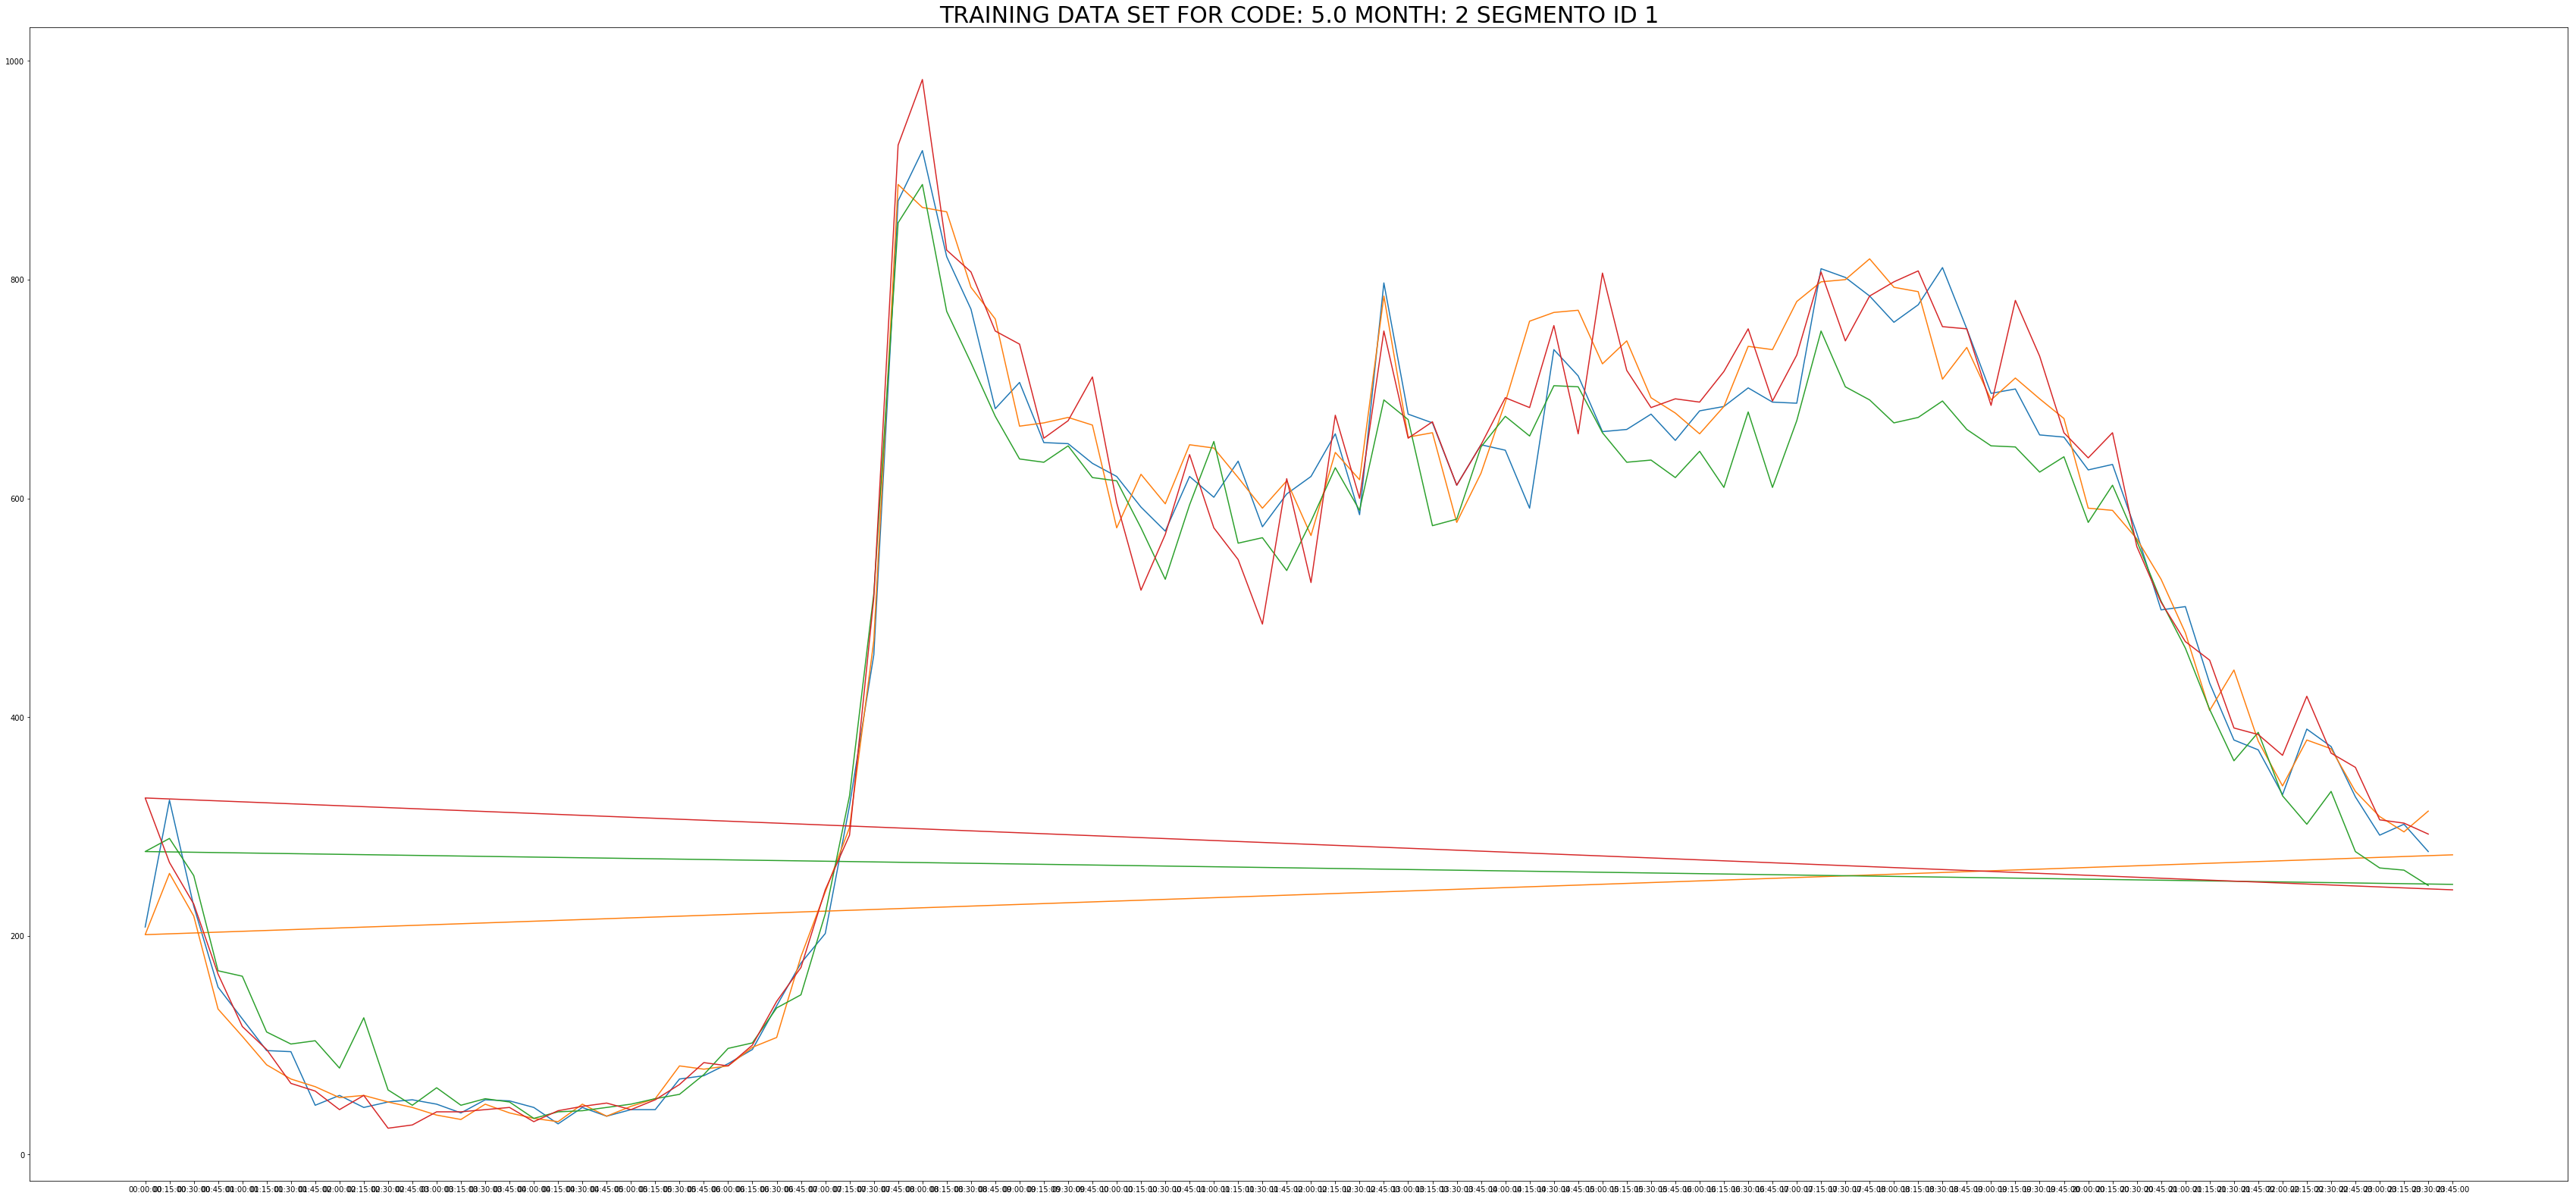

KeyboardInterrupt: 

In [17]:
months=[1,2]
segments=[1]
import matplotlib.pyplot as plt

for month_i in months: # Months 1 y 2
    for seg_id in segments: # Segment 1
        for code_i in df_month_seg.COD_LABORALIDAD.unique(): # All codes present
            df_train = df_training_sets.loc[(df_training_sets.MES==month_i)&(df_training_sets.ID_SEGMENT==seg_id)&(df_training_sets.COD_LABORALIDAD==code_i)]['TRAINING_SET'].iloc[0]
            # Plot training days
            plt.figure(figsize=(60,28))
            plt.title('TRAINING DATA SET FOR CODE: ' + str(code_i) + ' MONTH: ' + str(month_i) + ' SEGMENTO ID ' + str(seg_id) ,  fontsize=30)
            i=0
            for niter in range(int(len(df_train.index)/96)):
                plt.plot(df_train.TIME[i:i+96], df_train.TOTAL_VEHICULOS[i:i+96], marker='', label=str("Model - Code " + str(code_i) + ' month: ' + str(month_i) + ' segment: ' + str(seg_id)))
                i=i+96
plt.legend(loc='best',  fontsize=5)
plt.show()

### Generate Model csv

In [14]:
fb_model_data_dict = {'MINUTE':[], 'HOUR':[], 'ID_SEGMENT':[], 'MES':[], 'DAY':[], 'TOTAL_VEHICULOS': []}

In [15]:
import matplotlib.pyplot as plt
import numpy as np
MODEL_NAME =  'fbprophet'

#segments=[1]
months=[3]#,4,5,6]
#codes=[2]

processed_segs=[]
processed_months=[]
processed_codes=[]

save_iter=0
reach_checkpoint=1
i_part=0

for month_i in months:#df_training_sets['MES'].unique(): # Months 
    # clean variables
    fcst=None
    future=None
    df_train=None
    fbprophet_ref=None
    
    # update iterations
    save_iter=save_iter+1
            
    for seg_id in df_training_sets['ID_SEGMENT'].unique(): # Segment
            df_train = df_training_sets.loc[(df_training_sets.MES==int(month_i))&(df_training_sets.ID_SEGMENT==int(seg_id))]['TRAINING_SET'].iloc[0]
            
            # training transformation 
            df_training_prophet = df_train[['FECHA','TOTAL_VEHICULOS']].rename(columns={"FECHA": "ds", "TOTAL_VEHICULOS": "y"})
            df_training_prophet = df_training_prophet.reset_index(drop=True)
            df_training_prophet.drop_duplicates(subset=['ds', 'y'], keep='first', inplace=True)
            
            # Train fbprophet model
            time_resolution = 60*15 # 60 mint in 1 hour
            m = Prophet(changepoint_prior_scale=0.01).fit(df_training_prophet)
            future = m.make_future_dataframe(periods=time_resolution, freq='H')
            fcst = m.predict(future)
            
            # Take the modelled month
            fbprophet_ref=fcst.loc[fcst.ds.dt.month==month_i]
            
            # Fill model_data_dict with the model curve
            fb_model_data_dict['ID_SEGMENT'].extend([int(seg_id)]*len(fbprophet_ref.ds.values))
            fb_model_data_dict['MES'].extend(fbprophet_ref.ds.dt.month)
            fb_model_data_dict['DAY'].extend(fbprophet_ref.ds.dt.day)
            fb_model_data_dict['HOUR'].extend(fbprophet_ref.ds.dt.hour)
            fb_model_data_dict['MINUTE'].extend(fbprophet_ref.ds.dt.minute)
            fb_model_data_dict['TOTAL_VEHICULOS'].extend(fbprophet_ref.yhat.astype(int))
    
            # store checkpoint info (for saving the results)
            processed_segs.append(int(seg_id))
            processed_months.append(int(month_i))
    
    if save_iter >= reach_checkpoint:
        df_fb_model = pd.DataFrame(fb_model_data_dict)
        df_fb_model.to_csv(str(i_part) + "_fbprophet" + ".csv", sep=";", index=False)

        print("Saving results.... File part: "+ str(i_part)  )
        print("Processed segments: " +  str(set(processed_segs)))
        print("Processed months: " +  str(set(processed_months)))
        i_part=i_part+1

        # clean variables
        df_fb_model = None
        save_iter=0
        fb_model_data_dict = {'MINUTE':[], 'HOUR':[], 'ID_SEGMENT':[], 'MES':[], 'DAY':[], 'TOTAL_VEHICULOS': []}

c:\users\yhoz\.conda\envs\predictive.analytics\lib\site-packages\fbprophet\forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\users\yhoz\.conda\envs\predictive.analytics\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbp

Saving results.... File part: 0
Processed segments: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
Processed months: {3}
